# Slalom case study: Fraud classification

In [1]:
pwd

'/Users/ryanrappa/Desktop/GoogleDrive/ds/kaggle_tools/notebooks'

In [2]:
cd ..

/Users/ryanrappa/Desktop/GoogleDrive/ds/kaggle_tools


In [539]:
import pandas as pd
import numpy as np
import datetime
from scipy import stats
from src.classification import Classification, ConfusionMatrix
from src.eda import EDA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve

In [4]:
df = pd.read_csv('data/Fraud_Data.csv')

## **Cleaning, feature engineering, and EDA**

In [13]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [16]:
df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [117]:
print(sum(df['class'])) #count of fraud cases
sum(df['class']) / len(df) #pct of fraud cases

14151


0.09364577267192546

### Mapping IP addresses to countries, where possible

In [19]:
countries = pd.read_csv('data/IpAddress_to_Country.csv')

In [26]:
countries.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [35]:
countries.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


In [28]:
countries = countries.sort_values('lower_bound_ip_address')

In [40]:
def special_binary_search(arr, arr2, target):
    l = 0
    r = len(arr)-1
    while l < r:
        mid = (l+r) // 2
        if arr[mid] <= target and target <= arr2[mid]:
            return mid
        else:
            if arr[mid] > target:
                r = mid - 1
            else:
                l = mid + 1
    return None

In [41]:
def match_countries():
    for i in range(len(df)):
        ip = df.at[i, 'ip_address']
        idx = special_binary_search(countries['lower_bound_ip_address'],
                                   countries['upper_bound_ip_address'], 
                                   ip)
        if idx == None:
            df.at[i, 'country'] = "Unidentified"
        else:
            df.at[i, 'country'] = countries.at[idx, 'country']

In [46]:
match_countries()

In [52]:
len(df[df['country'] == 'Unidentified']) / len(df) #pct of unidentified countries

0.5435703319392239

In [80]:
sorted(list(df['country'].unique())) #checking for typos/errors

['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegowina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Congo The Democratic Republic of The',
 'Costa Rica',
 "Cote D'ivoire",
 'Croatia (LOCAL Name: Hrvatska)',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'European Union',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guam',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran (

In [81]:
df.head() #did a spot check here, looks like countries mapped correctly

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unidentified
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,Unidentified


### Making sure all purchase_times > signup_times, and times make sense

In [85]:
for i in range(len(df)):
    if df.at[i, 'signup_time'] > df.at[i, 'purchase_time']:
        print("Houston, we have a problem")
    else:
        continue

In [90]:
print(df['signup_time'].max())
print(df['signup_time'].min())
print(df['purchase_time'].max())
print(df['purchase_time'].min())

2015-08-18 04:40:29
2015-01-01 00:00:42
2015-12-16 02:56:05
2015-01-01 00:00:44


### Engineering time-related features

In [96]:
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


In [101]:
def get_timedeltas():
    '''
    Creates a column with the time elapsed from
    signup to purchase for each row, in seconds
    '''
    for i in range(len(df)):
        delta = (df.at[i, 'purchase_time'] - df.at[i, 'signup_time']) / np.timedelta64(1, 's')
        df.at[i, 'time_elapsed'] = delta

In [102]:
get_timedeltas()

In [137]:
print(len(df[df['time_elapsed'] <= 60])) #num of rows with < 1 min elasped
print(len(df[(df['time_elapsed'] <= 60) & (df['class'] == 1)])) #num of rows with < 1 min elasped and fraud

7600
7600


In [142]:
#sub_minute: 1 if purchase_time minus signup_time <= 1 min, 0 otherwise
for i in range(len(df)):
    if df.at[i, 'time_elapsed'] <= 60:
        df.at[i, 'sub_minute'] = 1
    else:
        df.at[i, 'sub_minute'] = 0

In [146]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_elapsed,sub_minute
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,0.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,0.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unidentified,492085.0,0.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,Unidentified,4361461.0,0.0


In [153]:
#creating columns with hour, to see if certain hours of the day have more fraud
df['signup_hour'] = df['signup_time'].dt.hour
df['purchase_hour'] = df['purchase_time'].dt.hour

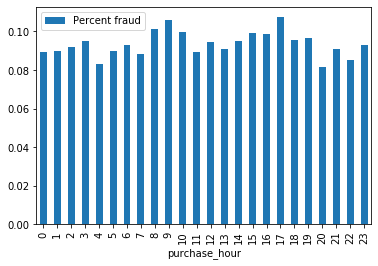

In [205]:
ax = df['class'].groupby(df['purchase_hour']).mean().plot(kind='bar')
ax.legend(["Percent fraud"])

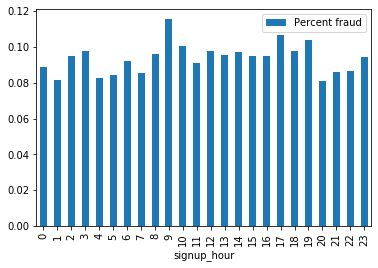

In [208]:
ax = df['class'].groupby(df['signup_hour']).mean().plot(kind='bar')
ax.legend(["Percent fraud"])

#### Does it matter if the device has been used before?

In [148]:
len(df['device_id'].unique())

137956

In [161]:
df = df.sort_values('purchase_time')

In [172]:
#device_used_prev: 1 if device has been used before, 0 if not
df['device_used_prev'] = df.duplicated(subset='device_id', keep='first').astype('int')

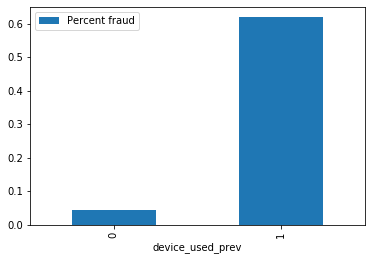

In [204]:
ax = df['class'].groupby(df['device_used_prev']).mean().plot(kind='bar')
ax.legend(["Percent fraud"])

### Making dummies for source, browser, sex, country - *for visualization*

In [215]:
df['browser'].unique()

array(['Chrome', 'IE', 'Safari', 'FireFox', 'Opera'], dtype=object)

In [214]:
df['source'].unique()

array(['Ads', 'SEO', 'Direct'], dtype=object)

In [216]:
df['sex'].unique()

array(['F', 'M'], dtype=object)

In [231]:
df_for_viz = pd.get_dummies(df, columns=['source', 'browser', 'sex', 'country']).select_dtypes(['number']) 
#not including drop_first=True in .get_dummies for viz purposes only
#.select_dtypes gives df with only numeric cols

In [244]:
X_cols = list(df_for_viz.columns)
X_cols.remove('class')
y_col = 'class'

### How else do frauds differ from legit transactions?

In [261]:
eda = EDA(df_for_viz, X_cols, y_col)

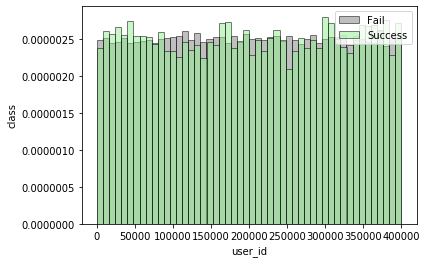

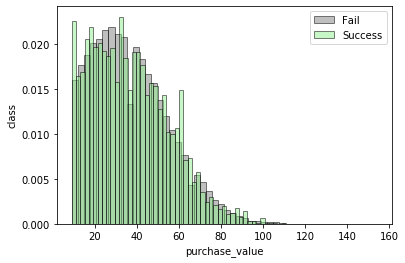

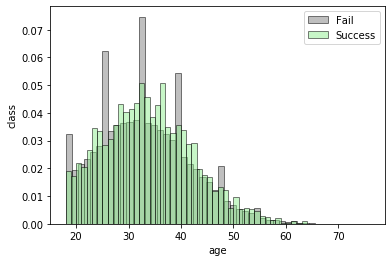

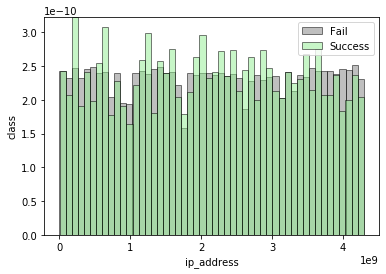

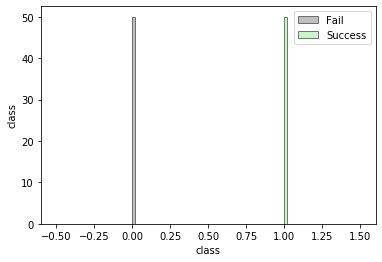

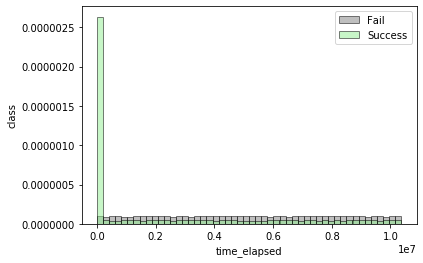

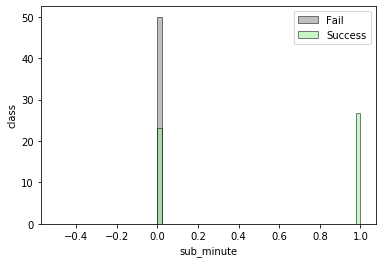

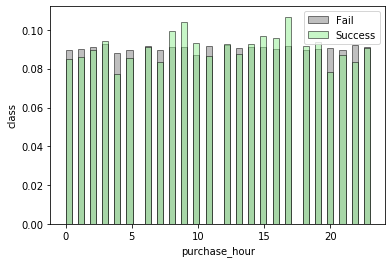

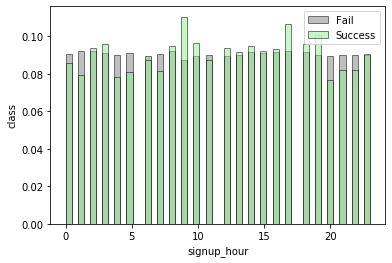

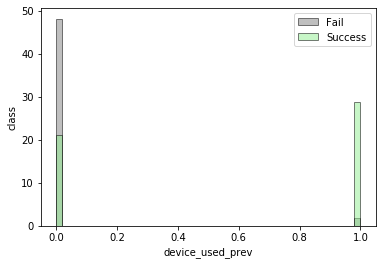

In [262]:
kwargs = {'density':True}
eda.histograms(hue=True, **kwargs)

# Legend: "Fail" => not fraud, "Success" => fraud
# y-axes are density

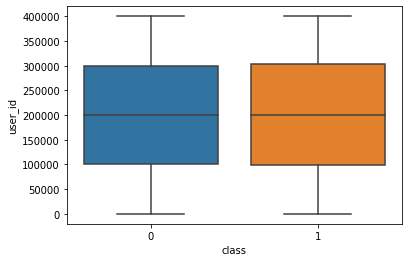

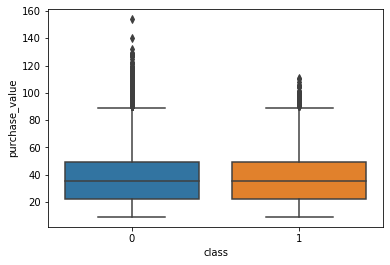

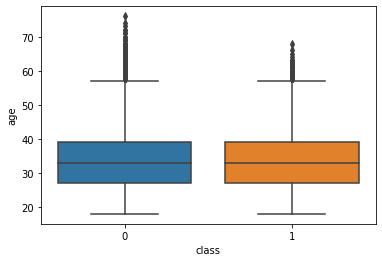

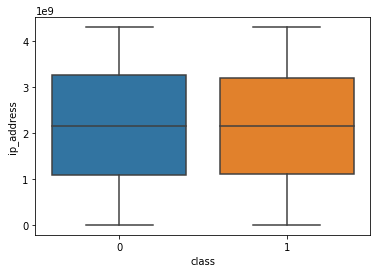

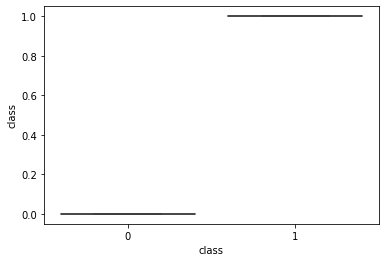

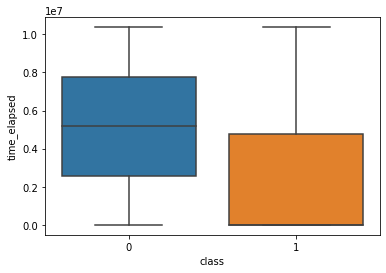

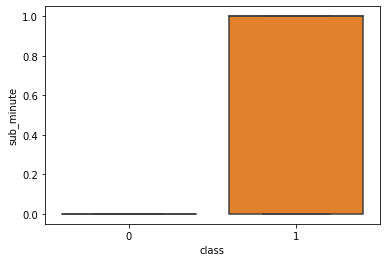

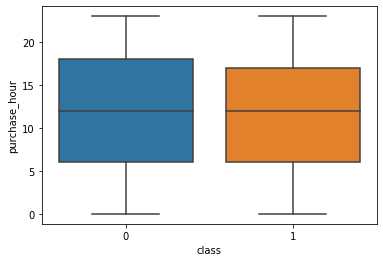

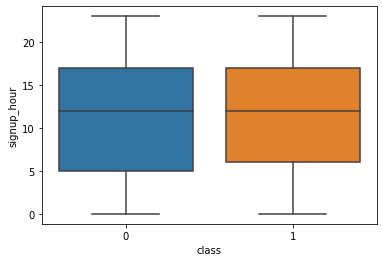

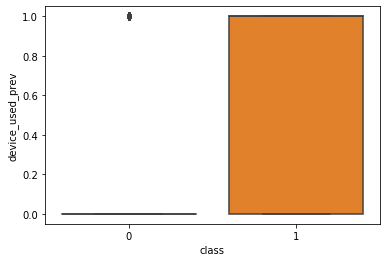

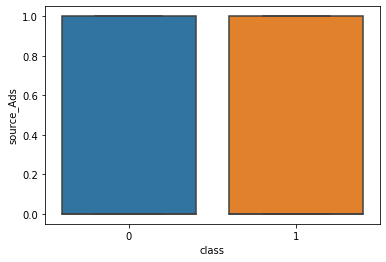

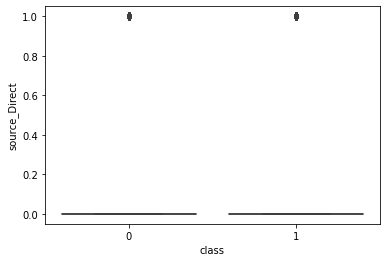

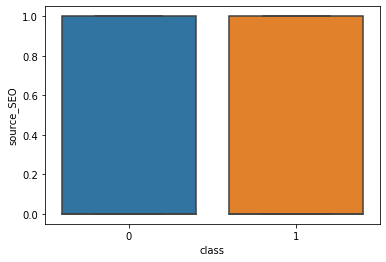

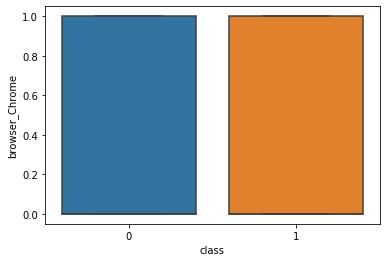

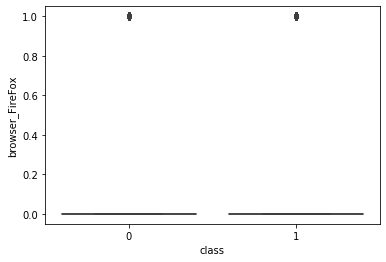

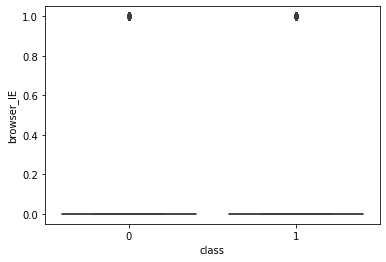

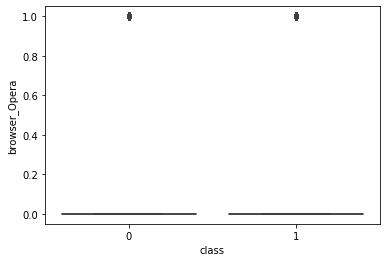

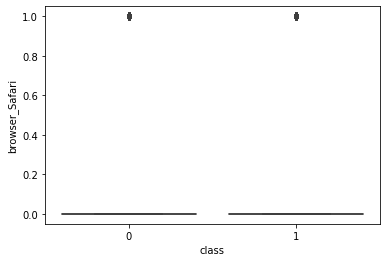

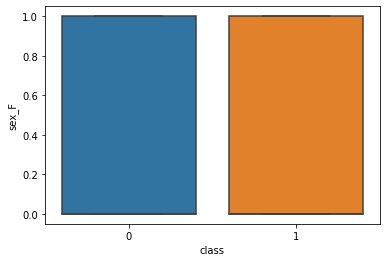

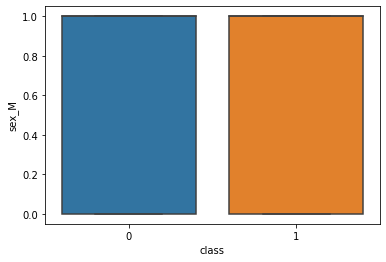

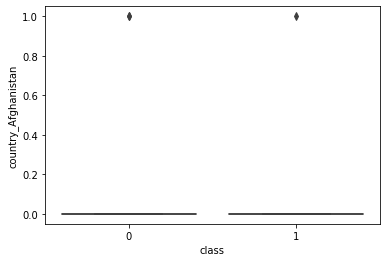

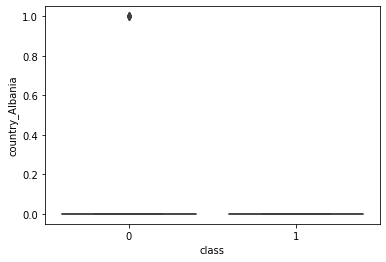

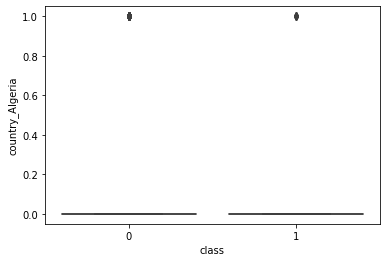

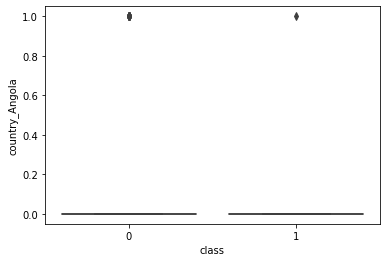

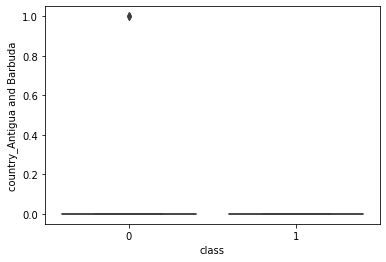

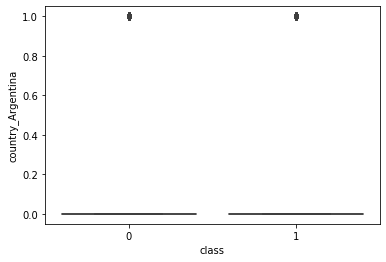

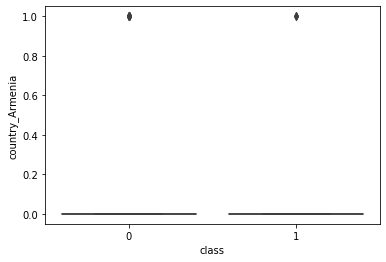

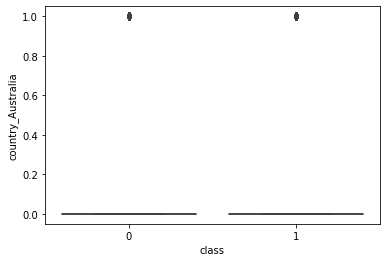

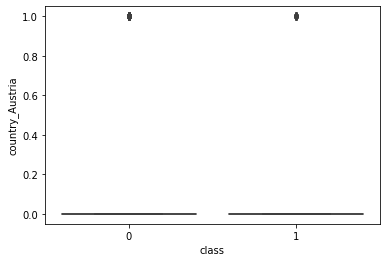

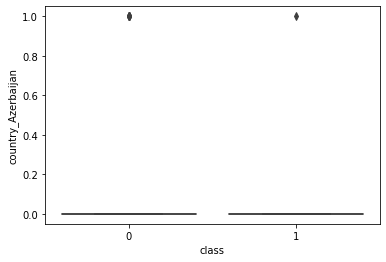

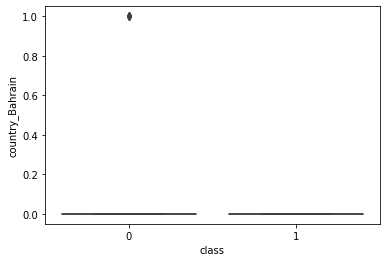

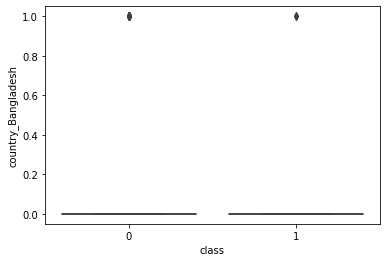

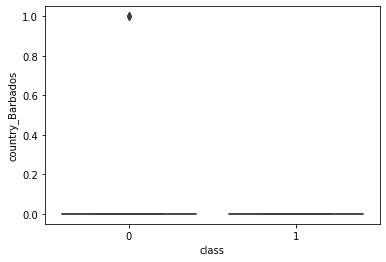

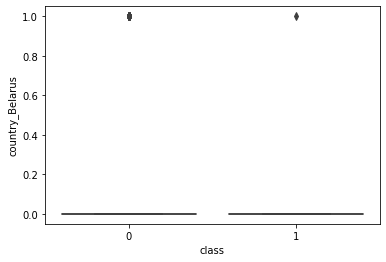

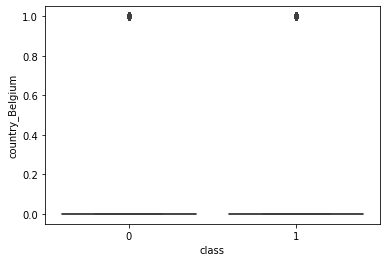

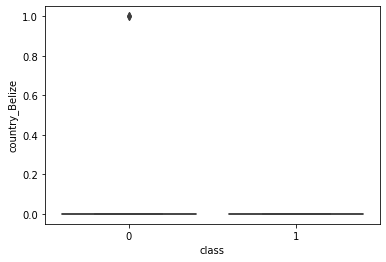

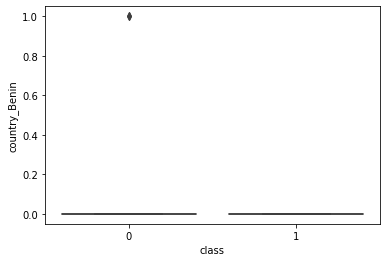

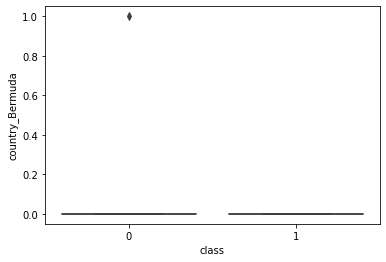

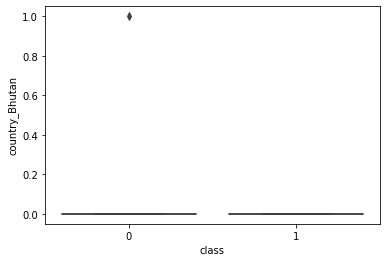

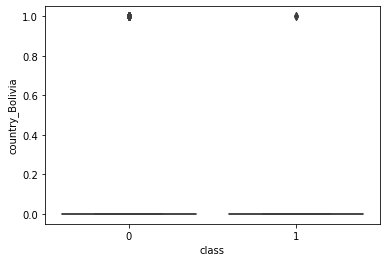

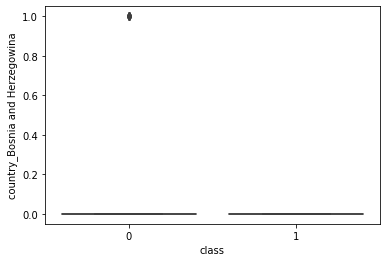

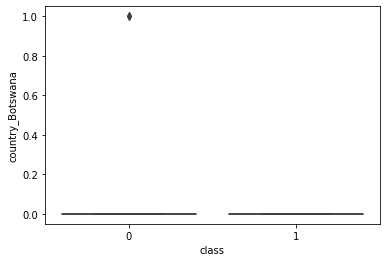

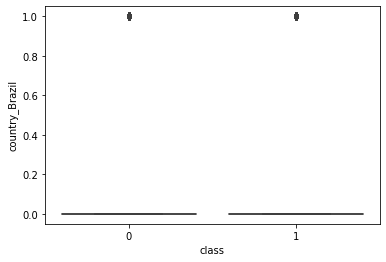

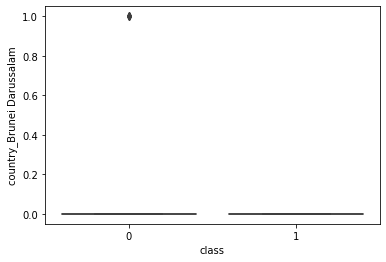

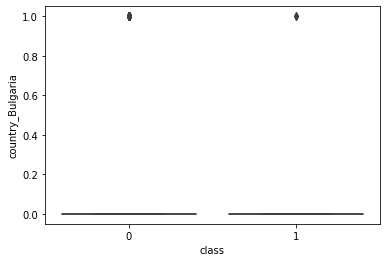

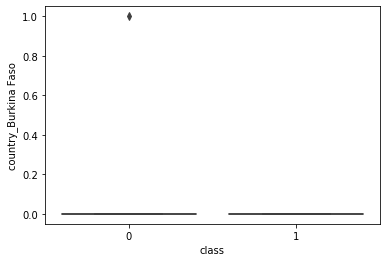

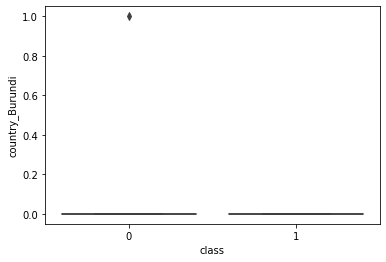

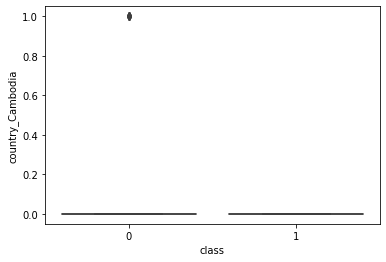

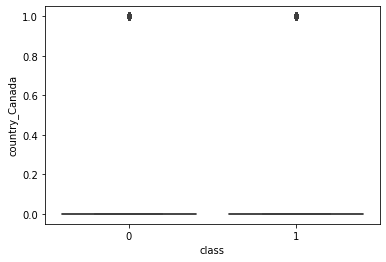

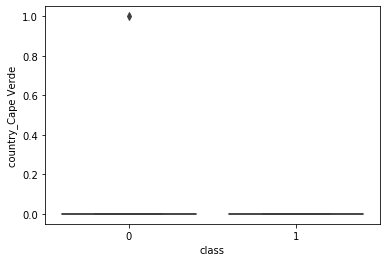

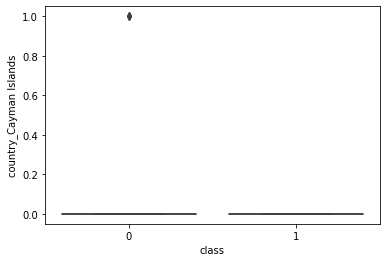

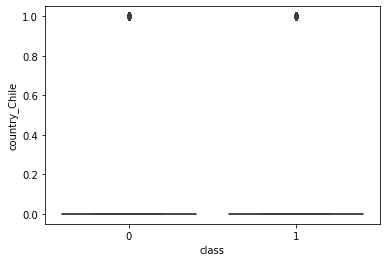

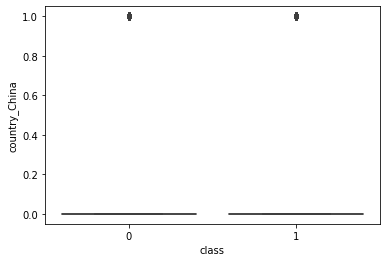

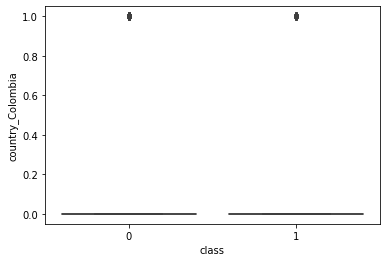

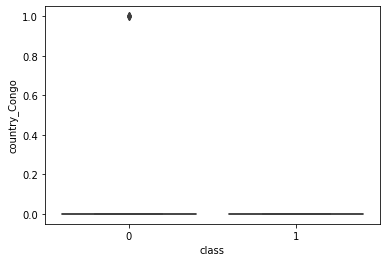

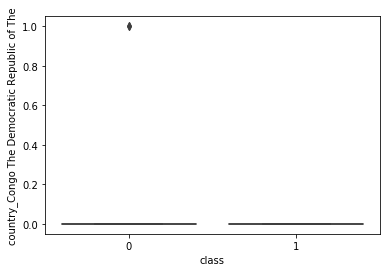

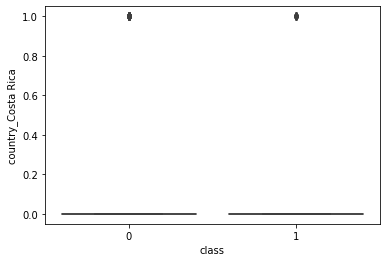

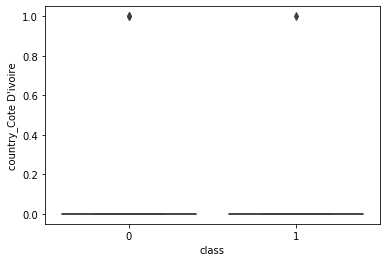

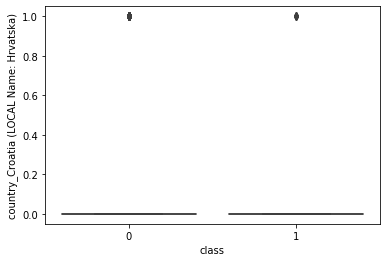

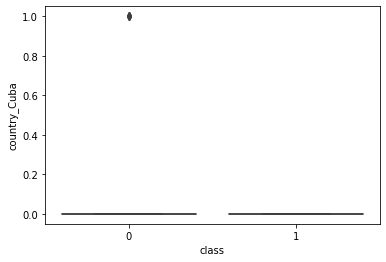

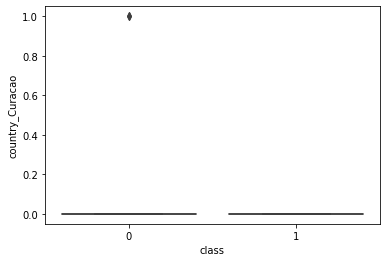

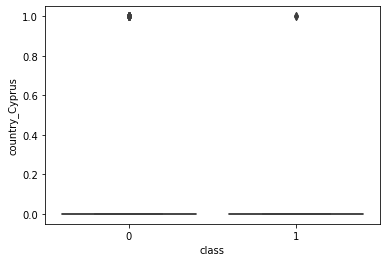

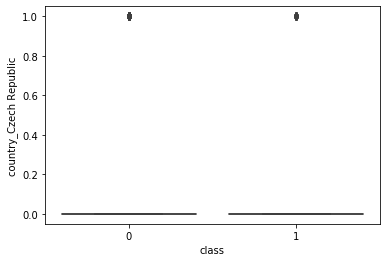

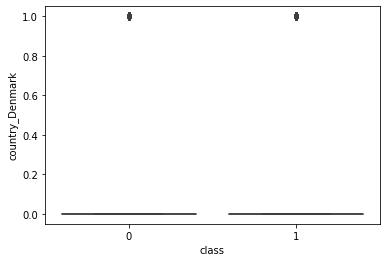

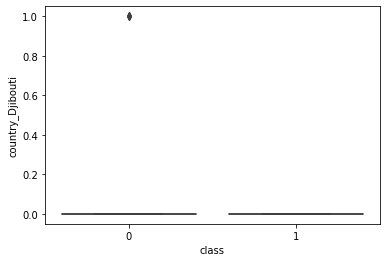

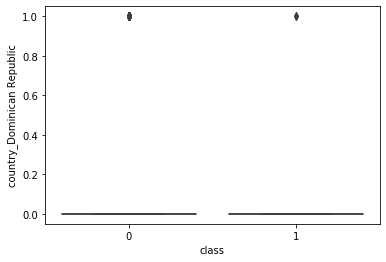

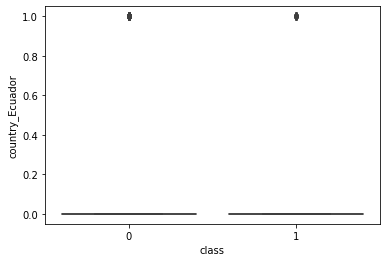

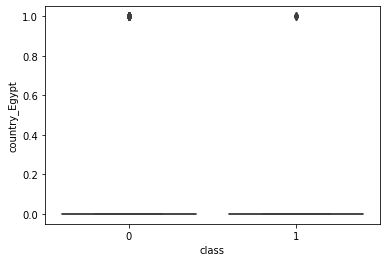

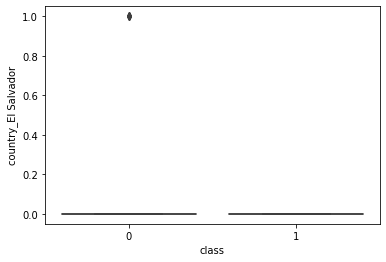

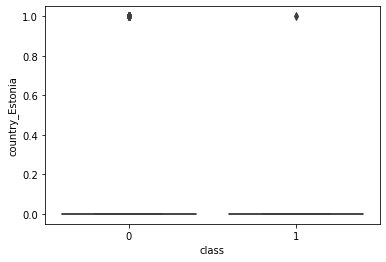

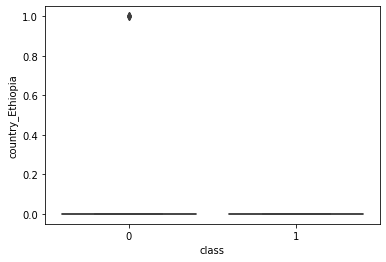

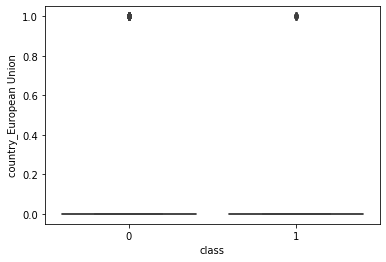

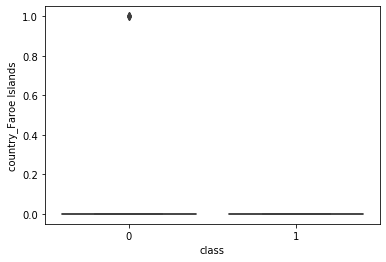

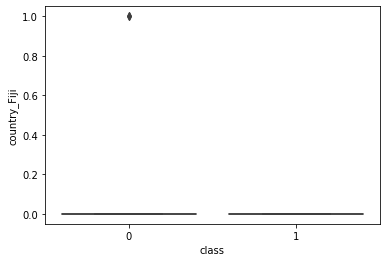

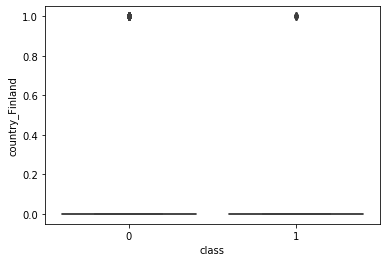

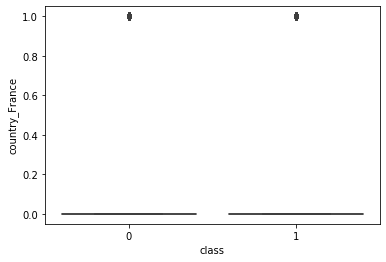

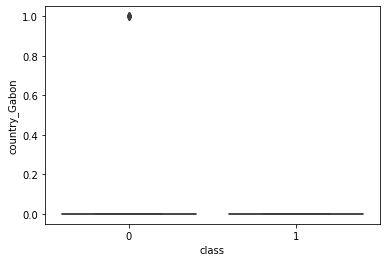

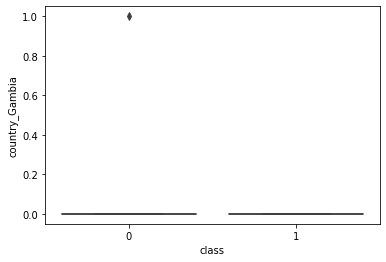

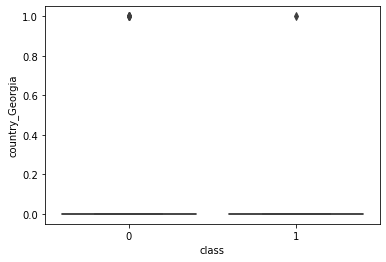

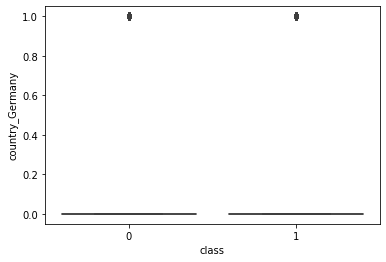

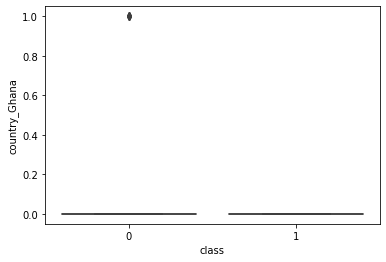

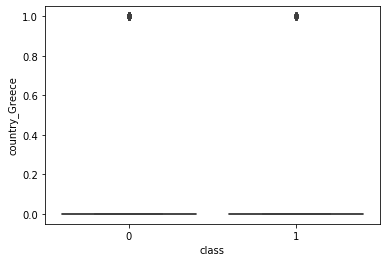

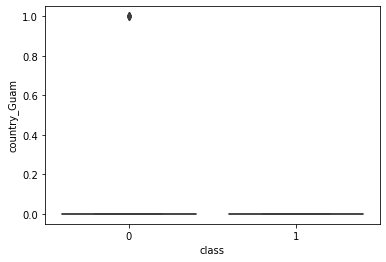

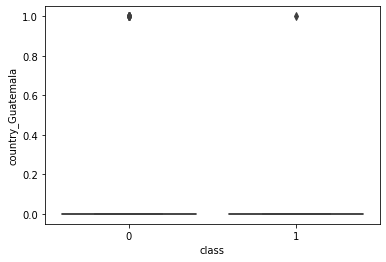

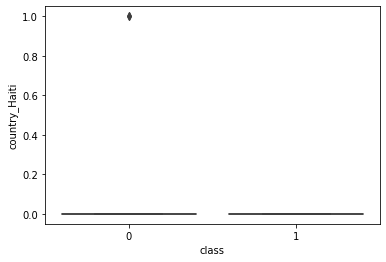

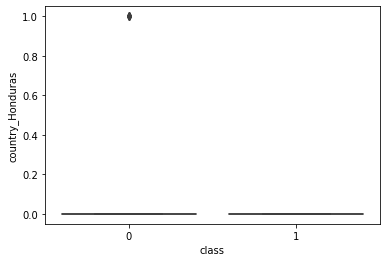

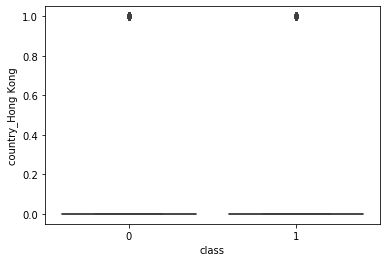

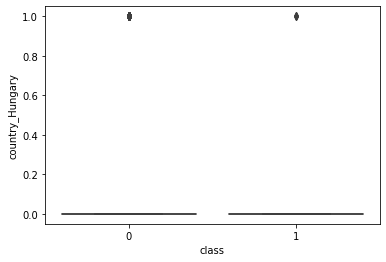

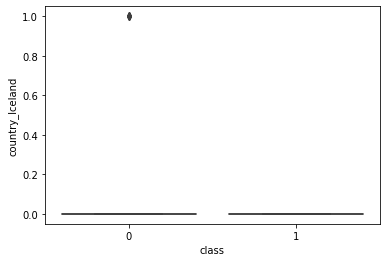

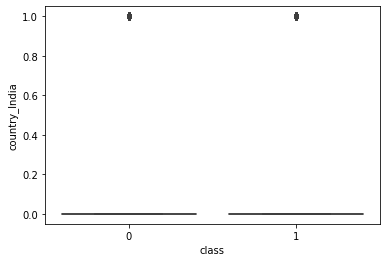

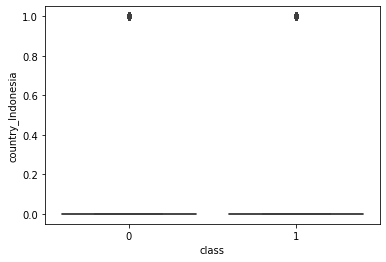

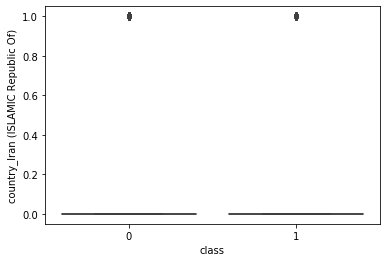

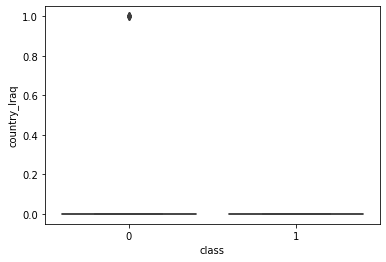

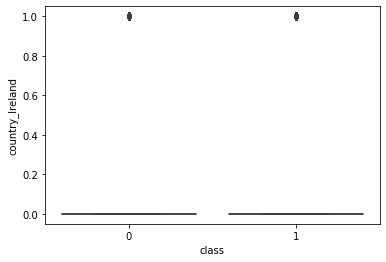

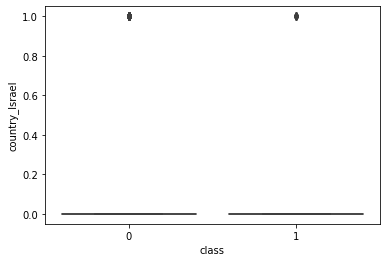

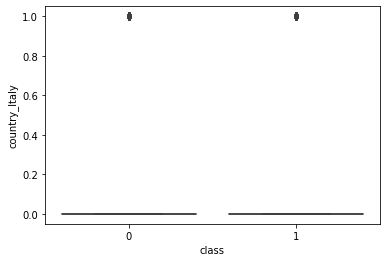

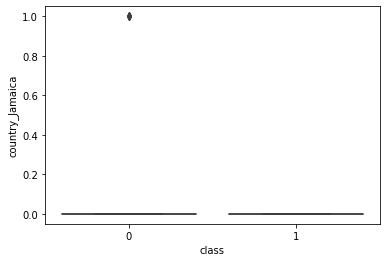

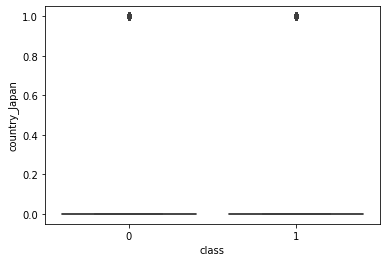

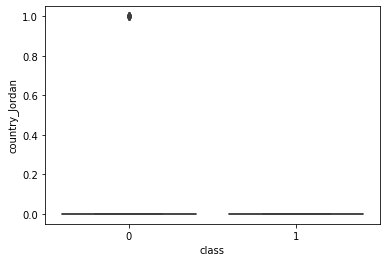

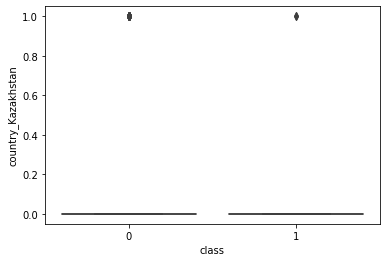

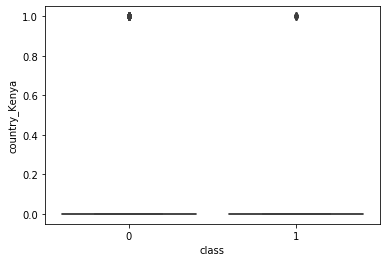

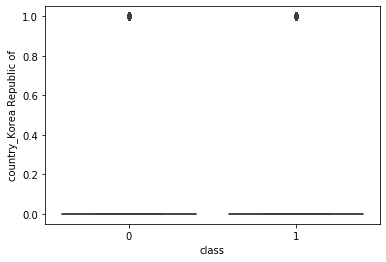

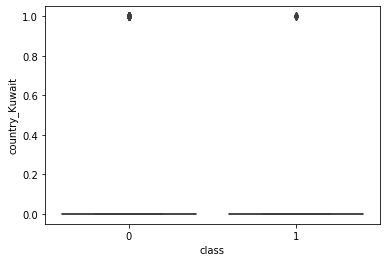

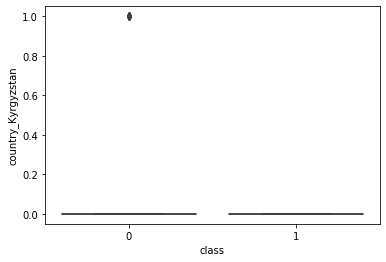

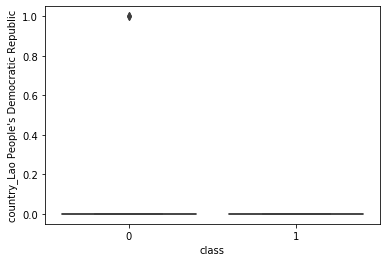

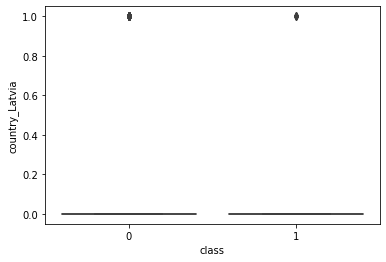

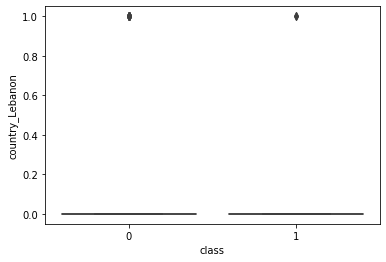

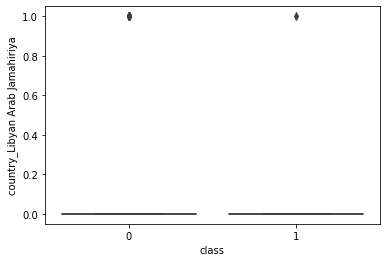

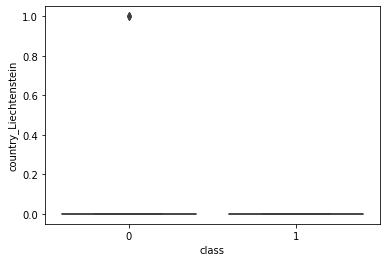

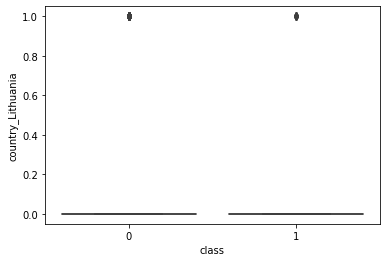

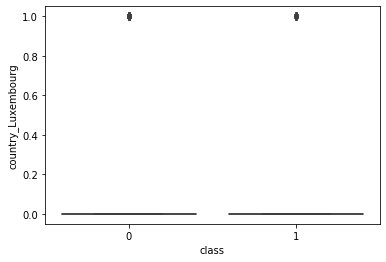

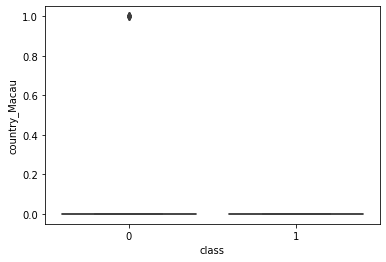

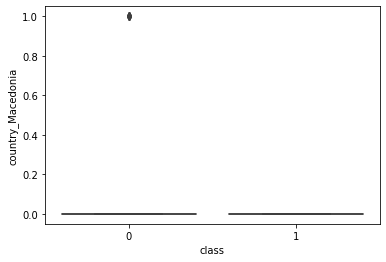

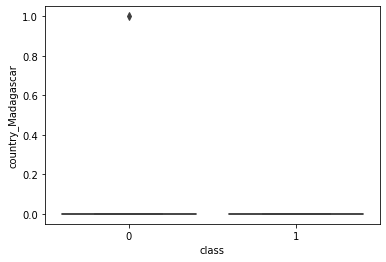

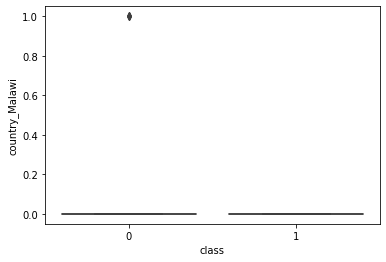

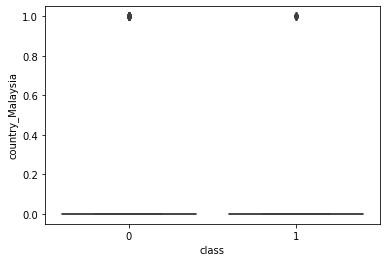

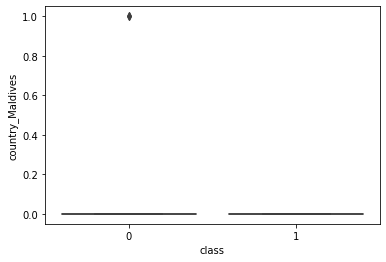

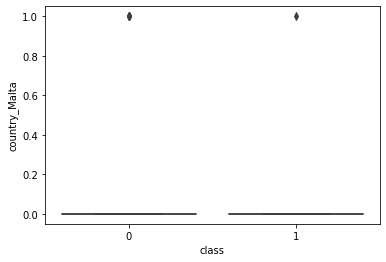

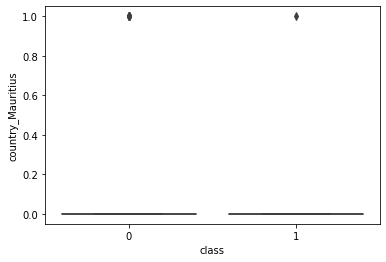

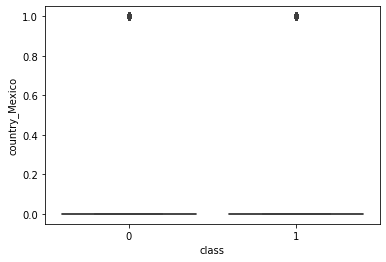

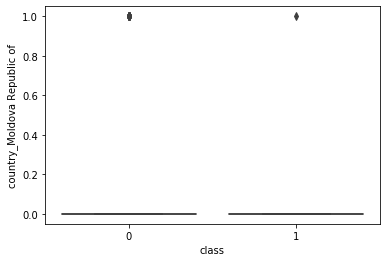

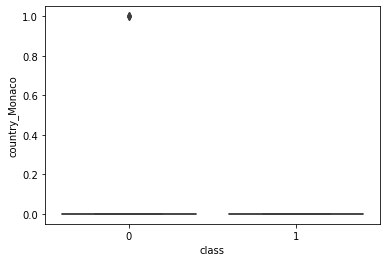

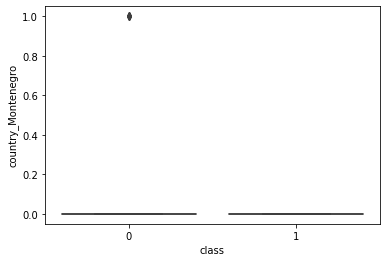

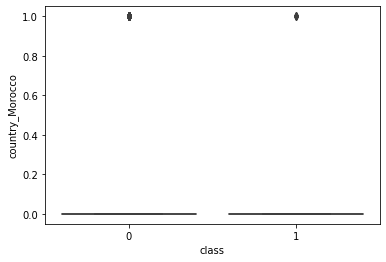

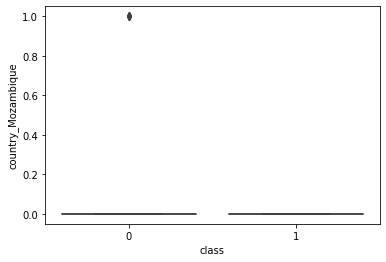

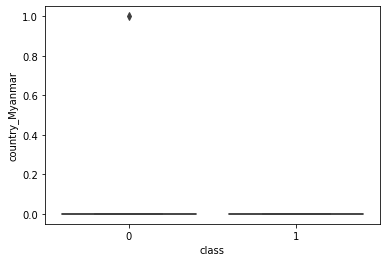

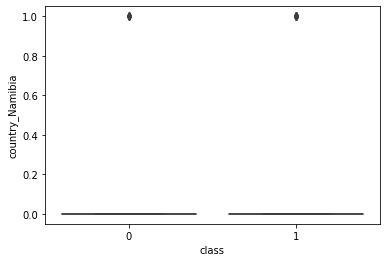

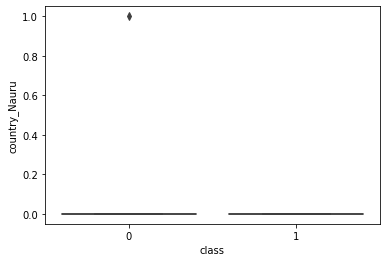

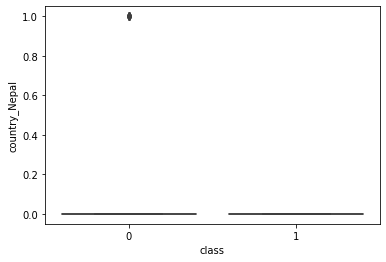

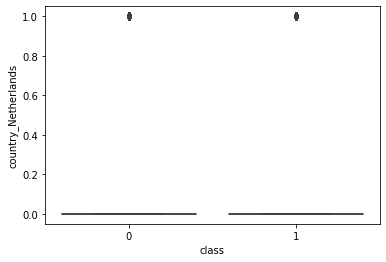

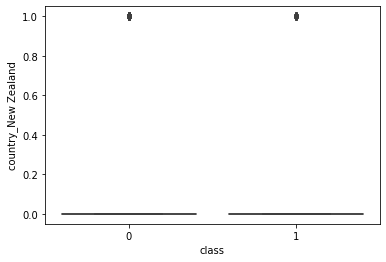

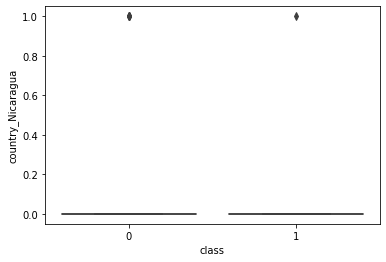

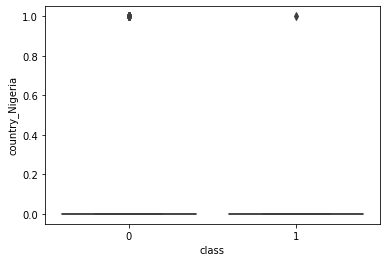

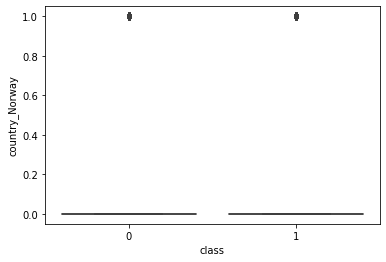

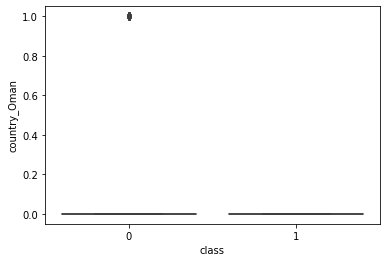

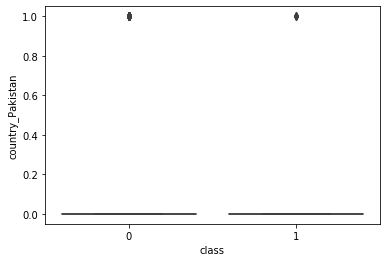

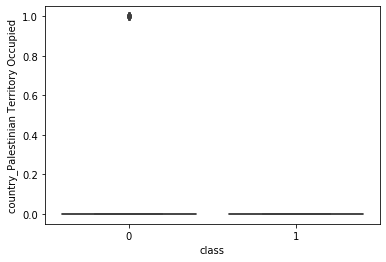

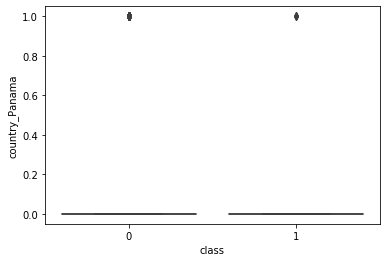

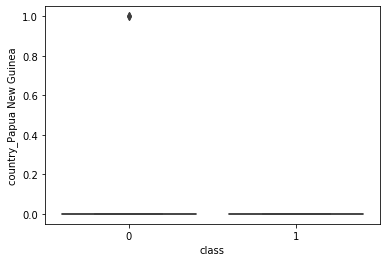

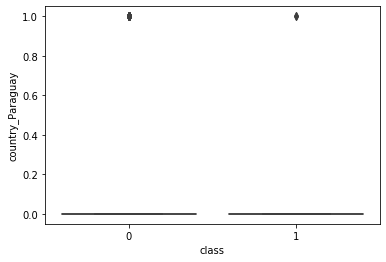

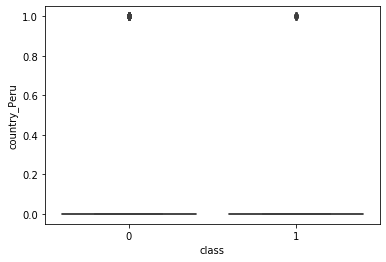

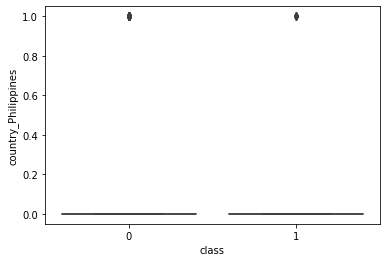

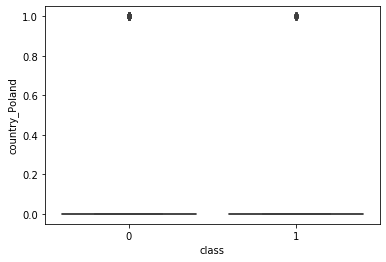

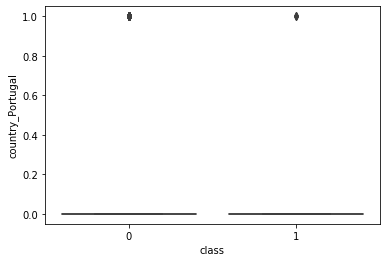

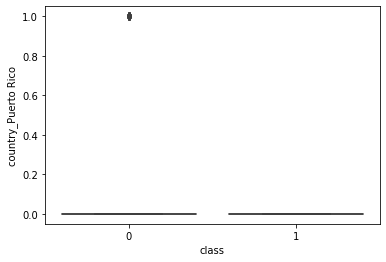

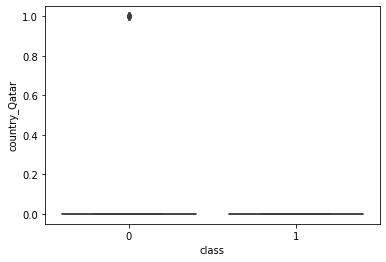

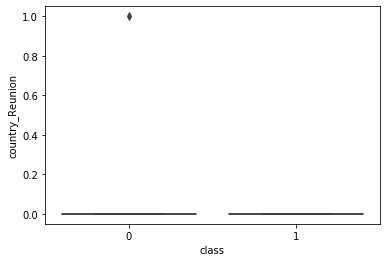

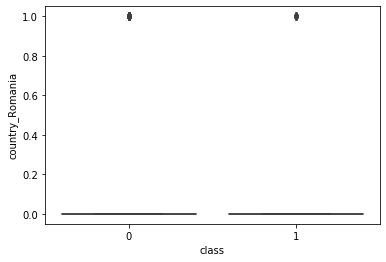

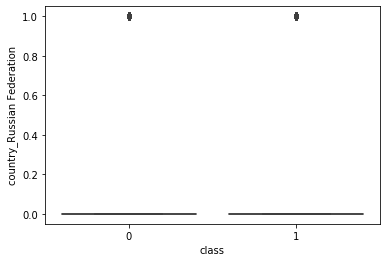

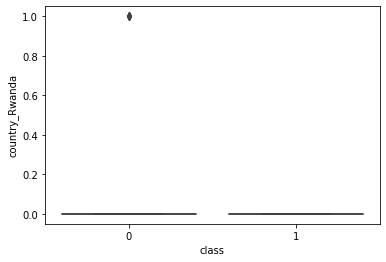

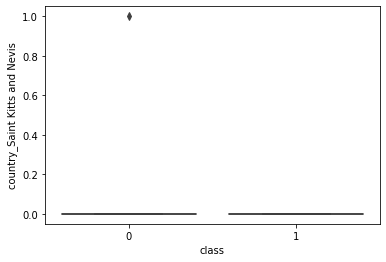

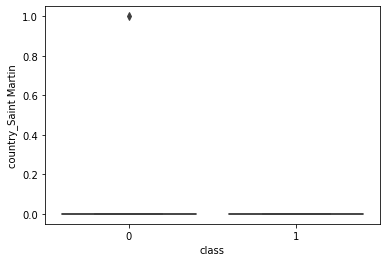

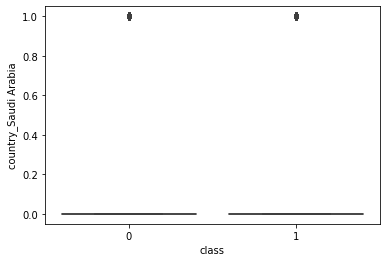

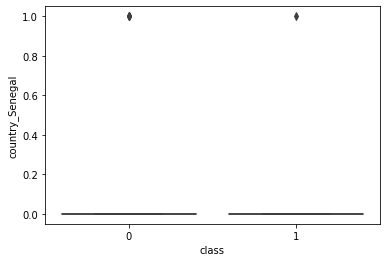

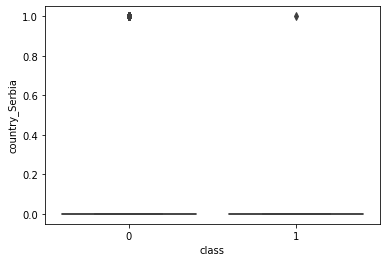

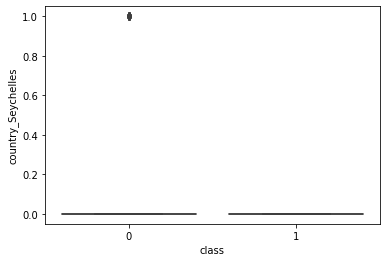

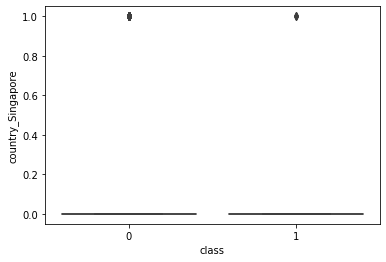

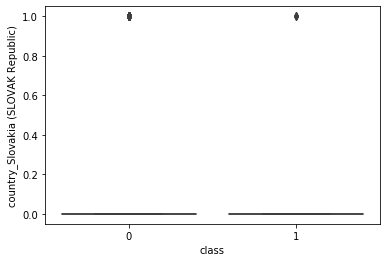

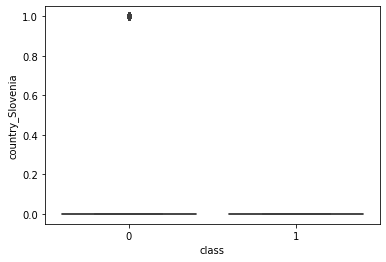

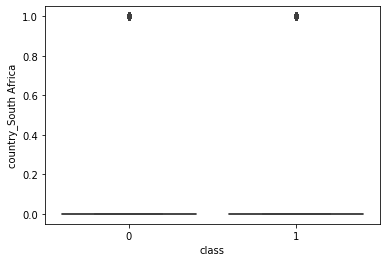

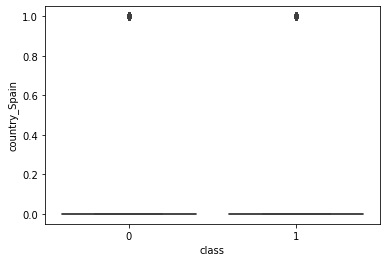

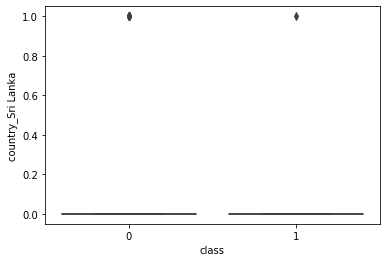

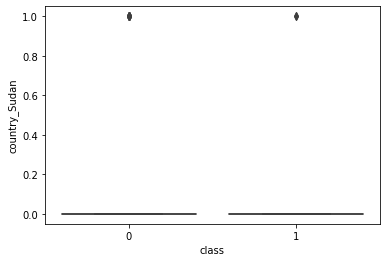

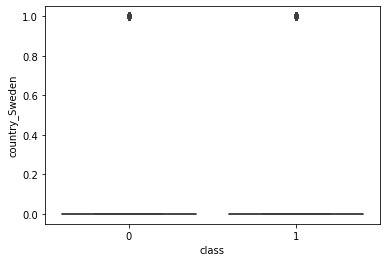

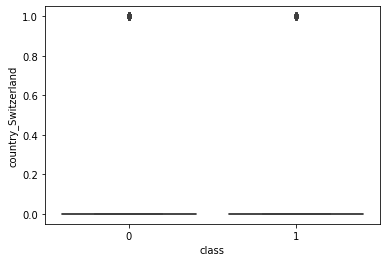

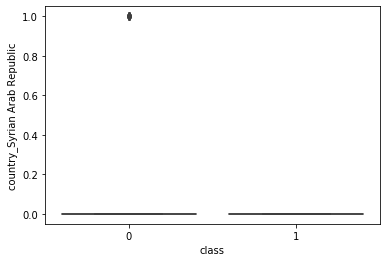

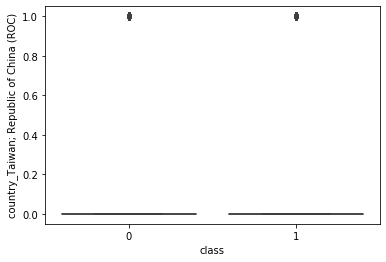

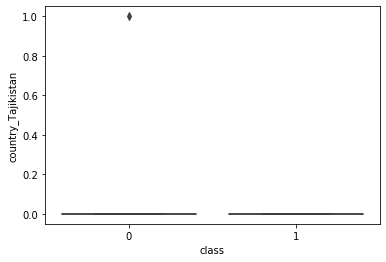

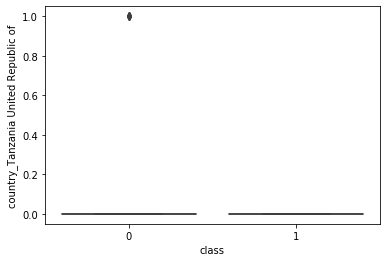

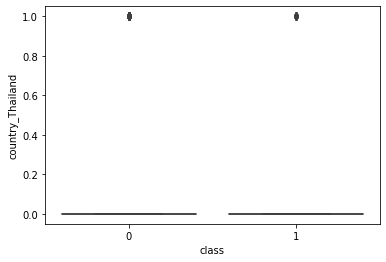

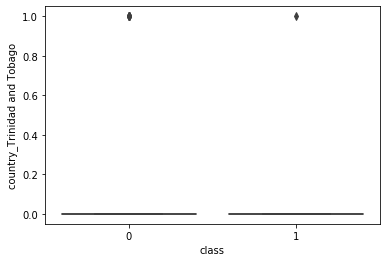

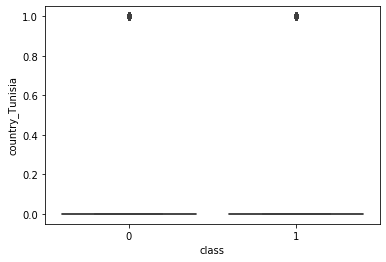

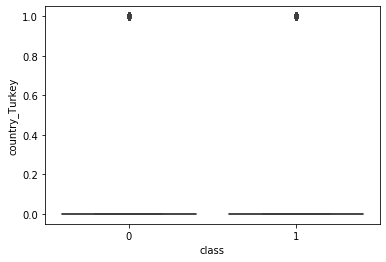

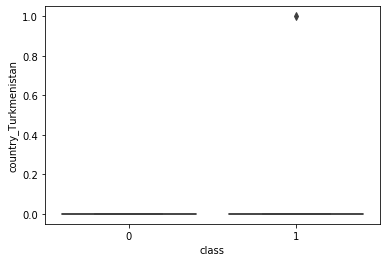

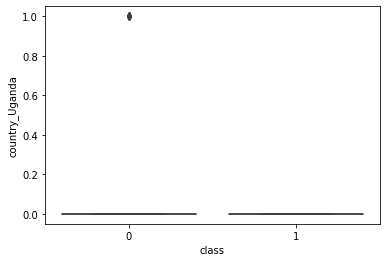

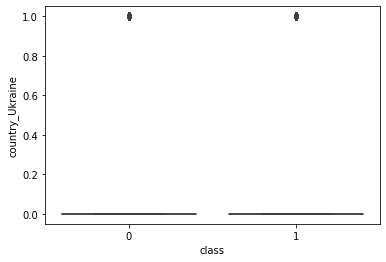

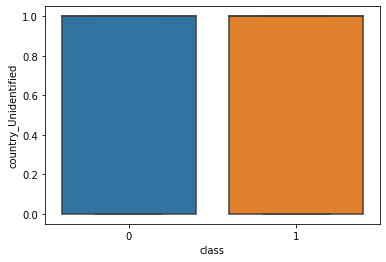

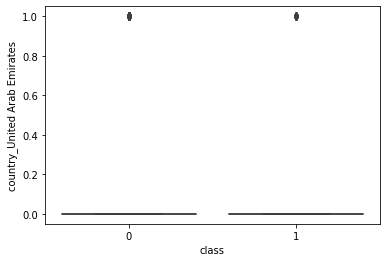

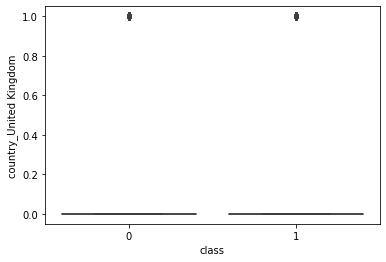

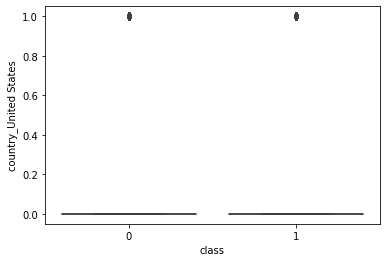

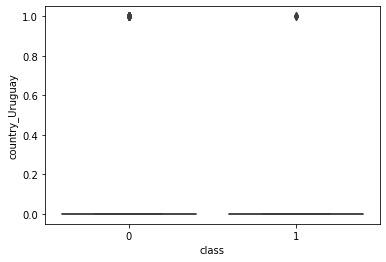

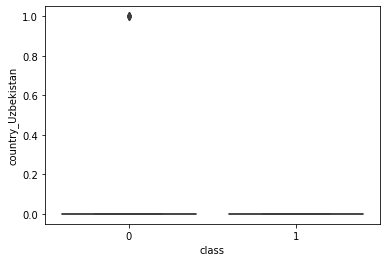

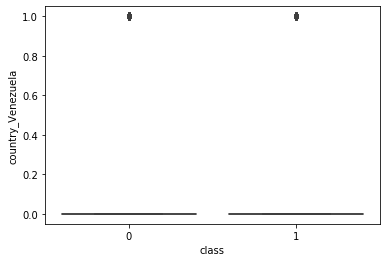

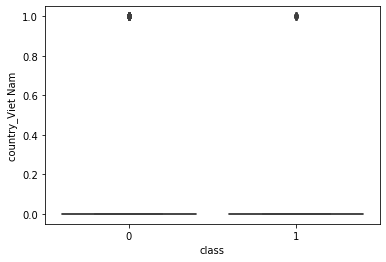

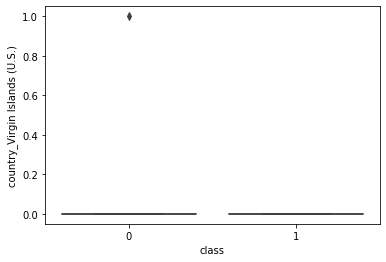

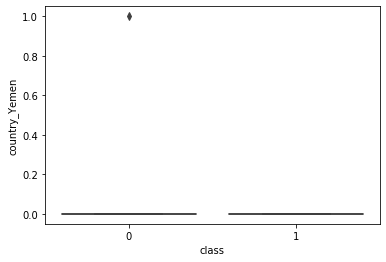

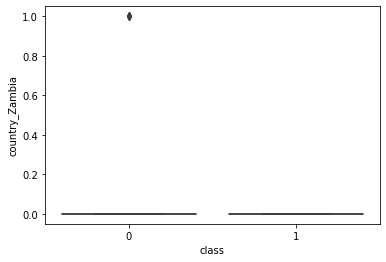

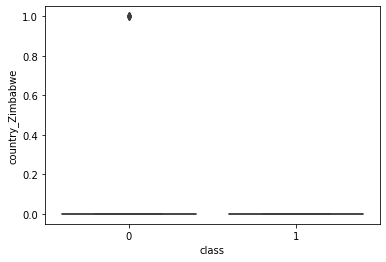

In [263]:
eda.boxplots(hue='class')
# almost 200 box plots in hidden cell below

In [ ]:
# check if the hour spikes from hists above coincide with sub_minute or something else 

### Having dummies for all countries is unwieldy; let's make counts and pct of fraud & legit to date for each row based on country

In [271]:
df = df.reset_index(drop=True)

In [310]:
def get_country_fraud_counts():
    fraud_counts = {}
    legit_counts = {}
    for i in range(len(df)):
        if df.at[i, 'class'] == 1:
            if df.at[i, 'country'] not in legit_counts:
                legit_counts[df.at[i, 'country']] = 0
                df.at[i, 'country_legit_cnt'] = 0
            else:
                df.at[i, 'country_legit_cnt'] = legit_counts[df.at[i, 'country']]
            if df.at[i, 'country'] not in fraud_counts:
                fraud_counts[df.at[i, 'country']] = 0
                df.at[i, 'country_fraud_cnt'] = 0
                fraud_counts[df.at[i, 'country']] += 1
            else:
                df.at[i, 'country_fraud_cnt'] = fraud_counts[df.at[i, 'country']]
                fraud_counts[df.at[i, 'country']] += 1
        elif df.at[i, 'class'] == 0:
            if df.at[i, 'country'] not in fraud_counts:
                fraud_counts[df.at[i, 'country']] = 0
                df.at[i, 'country_fraud_cnt'] = 0
            else:
                df.at[i, 'country_fraud_cnt'] = fraud_counts[df.at[i, 'country']]
            if df.at[i, 'country'] not in legit_counts:
                legit_counts[df.at[i, 'country']] = 0
                df.at[i, 'country_legit_cnt'] = 0
                legit_counts[df.at[i, 'country']] += 1
            else:
                df.at[i, 'country_legit_cnt'] = legit_counts[df.at[i, 'country']]
                legit_counts[df.at[i, 'country']] += 1

In [311]:
get_country_fraud_counts()

In [312]:
df['country_fraud_pct'] = df['country_fraud_cnt'] / (df['country_fraud_cnt'] + df['country_legit_cnt'])

In [316]:
#replacing country_fraud_pct NaNs (due to division by 0) with 0's
df['country_fraud_pct'].fillna(0, inplace=True)

### Let's do something similar for device

In [366]:
#device_fraud_prev: 1 if device has been used for fraud before, 0 if not
#device_legit_prev: 1 if device has been used for legit purchase before, 0, if not

def get_device_fraud_prev():
    fraud_devices = set()
    legit_devices = set()
    for i in range(len(df)):
        if df.at[i, 'class'] == 1:
            if df.at[i, 'device_id'] not in legit_devices:
                df.at[i, 'device_legit_prev'] = 0
            else:
                df.at[i, 'device_legit_prev'] = 1
            if df.at[i, 'device_id'] not in fraud_devices:
                fraud_devices.add(df.at[i, 'device_id'])
                df.at[i, 'device_fraud_prev'] = 0
            else:
                df.at[i, 'device_fraud_prev'] = 1
        elif df.at[i, 'class'] == 0:
            if df.at[i, 'device_id'] not in fraud_devices:
                df.at[i, 'device_fraud_prev'] = 0
            else:
                df.at[i, 'device_fraud_prev'] = 1
            if df.at[i, 'device_id'] not in legit_devices:
                legit_devices.add(df.at[i, 'device_id'])
                df.at[i, 'device_legit_prev'] = 0
            else:
                df.at[i, 'device_legit_prev'] = 1

In [320]:
get_device_fraud_prev()

In [346]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_elapsed,sub_minute,purchase_hour,signup_hour,device_used_prev,country_fraud_cnt,country_legit_cnt,country_fraud_pct,device_fraud_prev,device_legit_prev
0,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1.0,1.0,0,0,0,0.0,0.0,0.0,0,0.0
1,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1.0,1.0,0,0,1,1.0,0.0,1.0,1,0.0
2,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1.0,1.0,0,0,1,2.0,0.0,1.0,1,0.0
3,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1.0,1.0,0,0,1,3.0,0.0,1.0,1,0.0
4,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,1.0,1.0,0,0,1,4.0,0.0,1.0,1,0.0


In [345]:
len(df['device_id'].unique())

137956

In [343]:
#count of rows where device is known to have made both fraud and legit transactions
len(df[(df['device_fraud_prev'] == 1) & (df['device_legit_prev'] == 1)])

73

In [339]:
#looking at some devices that have made both fraud and legit transactions
df[df['device_id'].isin(list(df[(df['device_fraud_prev'] == 1) & (df['device_legit_prev'] == 1)]['device_id']))].sort_values(by=['device_id', 'purchase_time']).head(30)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_elapsed,sub_minute,purchase_hour,signup_hour,device_used_prev,country_fraud_cnt,country_legit_cnt,country_fraud_pct,device_fraud_prev,device_legit_prev
968,354773,2015-01-02 13:10:08,2015-01-02 13:10:09,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,0,454.0,2.0,0.995614,0,0.0
969,79937,2015-01-02 13:10:09,2015-01-02 13:10:10,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,455.0,2.0,0.995624,1,0.0
970,53560,2015-01-02 13:10:10,2015-01-02 13:10:11,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,456.0,2.0,0.995633,1,0.0
971,238130,2015-01-02 13:10:11,2015-01-02 13:10:12,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,457.0,2.0,0.995643,1,0.0
972,55775,2015-01-02 13:10:12,2015-01-02 13:10:13,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,458.0,2.0,0.995652,1,0.0
973,115386,2015-01-02 13:10:13,2015-01-02 13:10:14,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,459.0,2.0,0.995662,1,0.0
974,308000,2015-01-02 13:10:14,2015-01-02 13:10:15,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,460.0,2.0,0.995671,1,0.0
975,366905,2015-01-02 13:10:15,2015-01-02 13:10:16,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,461.0,2.0,0.995680,1,0.0
976,180531,2015-01-02 13:10:16,2015-01-02 13:10:17,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,1,Unidentified,1.0,1.0,13,13,1,462.0,2.0,0.995690,1,0.0
9699,175446,2015-01-02 13:10:07,2015-01-29 12:18:24,26,BDIRFSGFIWPEP,Direct,Chrome,M,25,5.094383e+08,0,Unidentified,2329697.0,0.0,12,13,1,3902.0,1064.0,0.785743,1,0.0


### Let's look again at the age and value bumps seen in the hists above

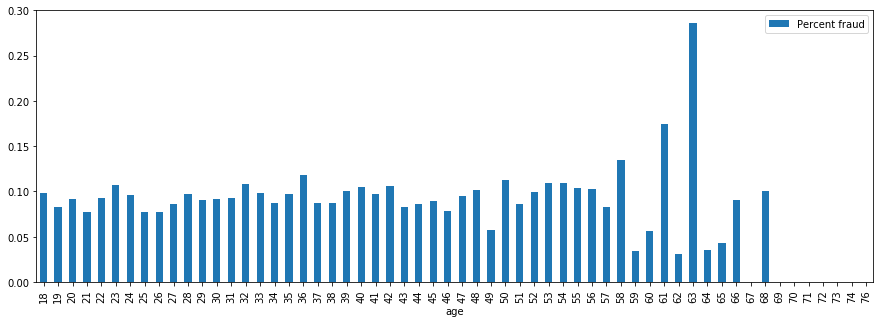

In [375]:
ax = df['class'].groupby(df['age']).mean().plot(kind='bar', figsize=(15,5))
ax.legend(["Percent fraud"])

In [383]:
print(len(df[df['age'] == 63]))
print(len(df[df['age'] == 61]))
print(len(df[df['age'] == 58]))
# relatively few observations at these ages, probably not a pattern meaningful for generalization 
len(df[df['class'] == 1]) #num of frauds in dataset

56
92
223


14151

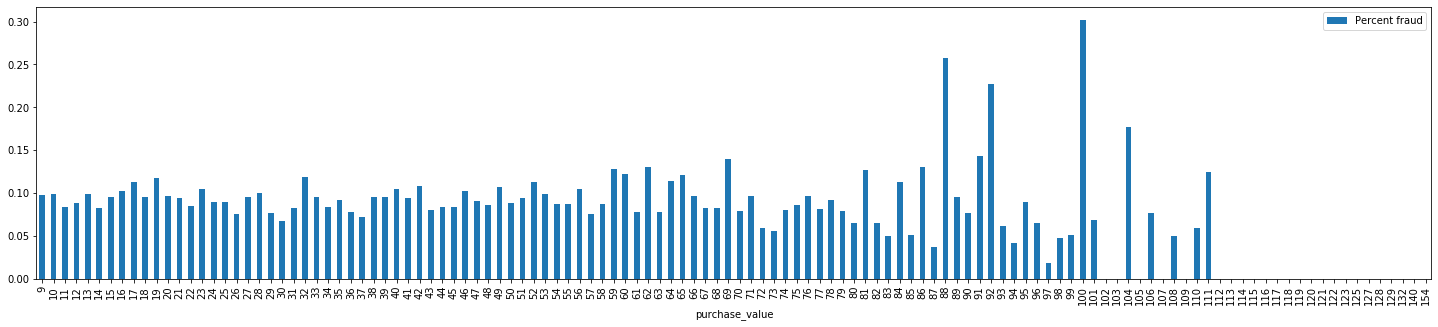

In [374]:
ax = df['class'].groupby(df['purchase_value']).mean().plot(kind='bar', figsize=(25,5))
ax.legend(["Percent fraud"])

In [385]:
print(len(df[df['purchase_value'] == 100]))
print(len(df[df['purchase_value'] == 88]))
print(len(df[df['purchase_value'] == 92]))
print(len(df[df['purchase_value'] == 104]))
# relatively few observations at these ages, probably not a pattern meaningful for generalization 
len(df[df['class'] == 1]) #num of frauds in dataset

53
171
128
17


14151

### Do I have a variable that helps capture the trends seen by hour? Yes.

0.9602215251416297
0.9350654598882512


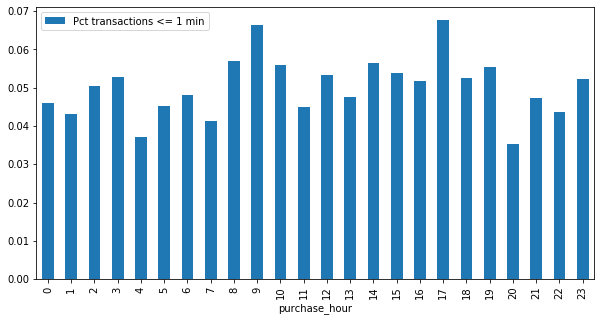

In [405]:
ax = df['sub_minute'].groupby(df['purchase_hour']).mean().plot(kind='bar', figsize=(10,5))
ax.legend(["Pct transactions <= 1 min"])
# looks like the impact of hour will largely be captured by sub_minute or time elapsed

print(df['sub_minute'].groupby(df['purchase_hour']).mean().corr(df['class'].groupby(df['purchase_hour']).mean()))
# Pearson's r of .96 btw the mean of sub_minute by purchase hour and mean of class by purchase hour

print(df['sub_minute'].groupby(df['signup_hour']).mean().corr(df['class'].groupby(df['signup_hour']).mean()))
# Pearson's r of .93 btw the mean of sub_minute by signup hour and mean of class by signup hour

### Making dummies for source, browser, sex - *for visualization pt. 2*

In [395]:
df_for_viz = pd.get_dummies(df, columns=['source', 'browser', 'sex']).select_dtypes(['number']) 
#not including drop_first=True in .get_dummies for viz purposes only
#.select_dtypes gives df with only numeric cols

In [396]:
X_cols = list(df_for_viz.columns)
X_cols.remove('class')
y_col = 'class'

#### How else might frauds differ from legit transactions?

In [397]:
eda = EDA(df_for_viz, X_cols, y_col)

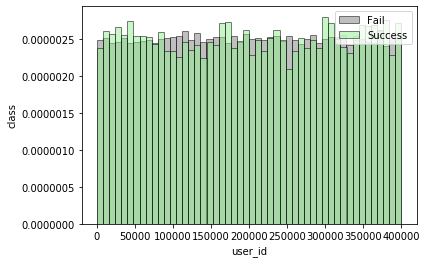

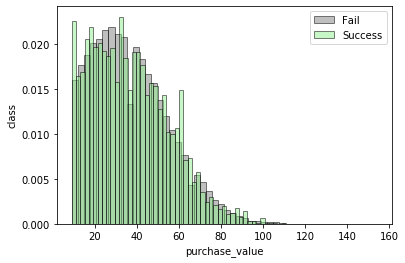

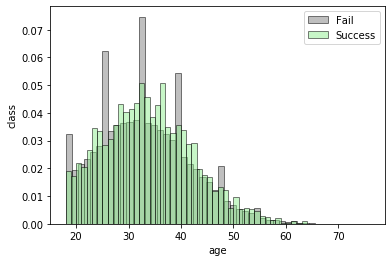

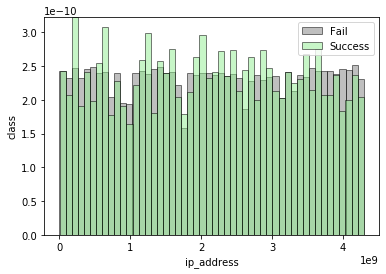

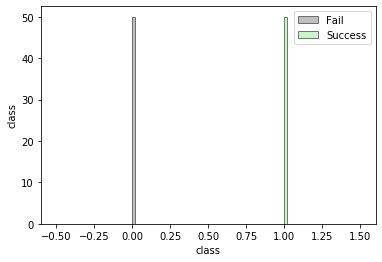

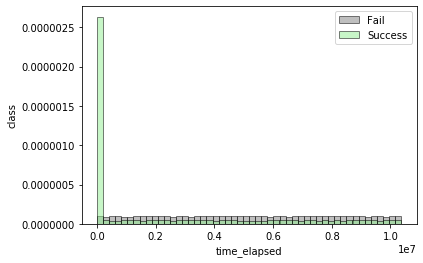

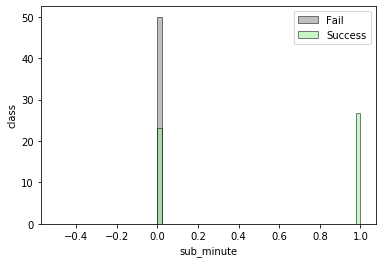

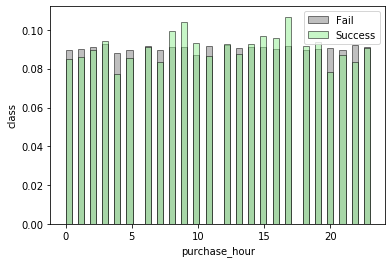

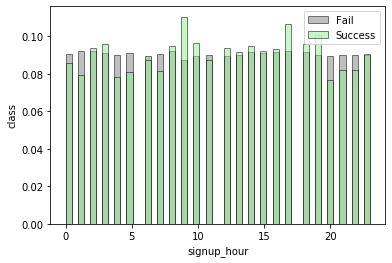

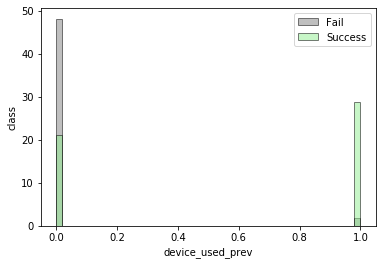

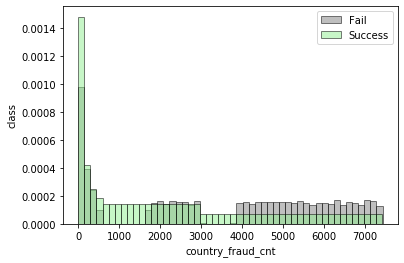

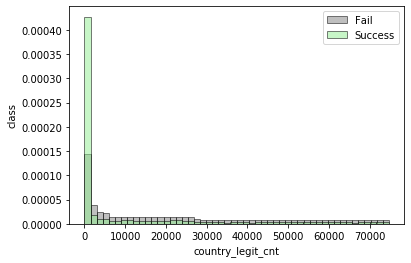

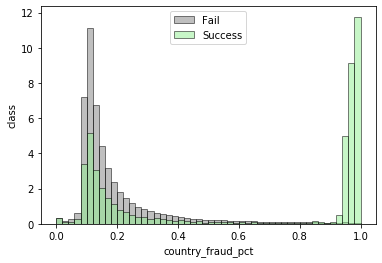

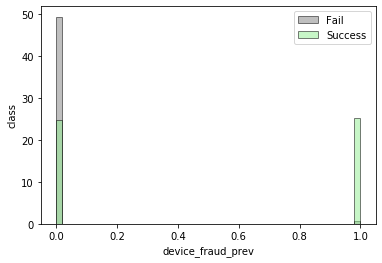

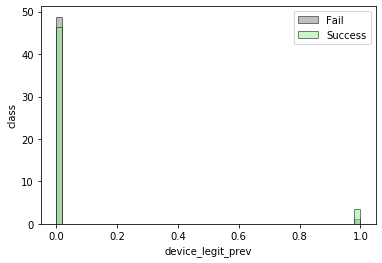

In [398]:
kwargs = {'density':True}
eda.histograms(hue=True, **kwargs)

# Legend: "Fail" => not fraud, "Success" => fraud
# y-axes are density

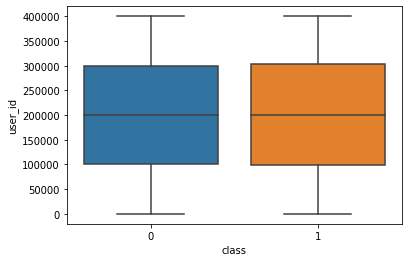

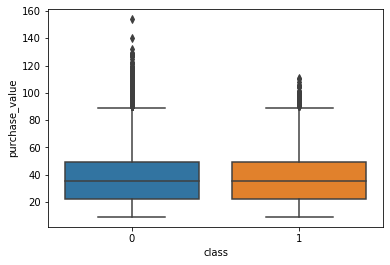

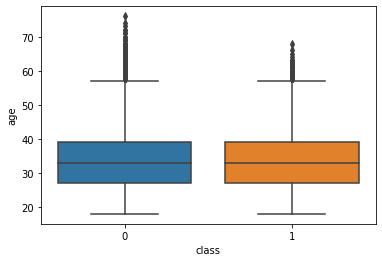

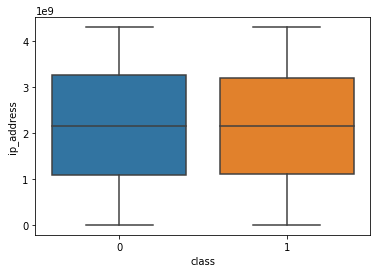

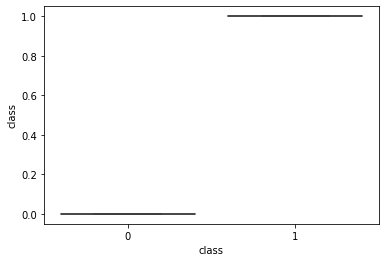

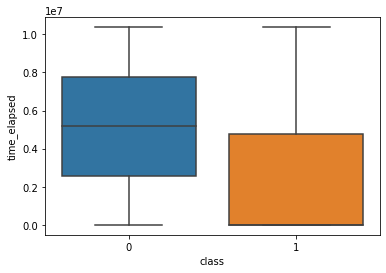

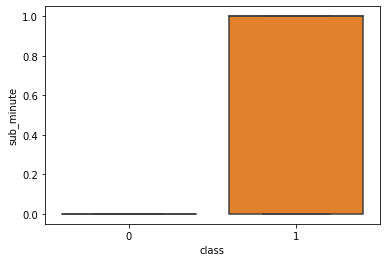

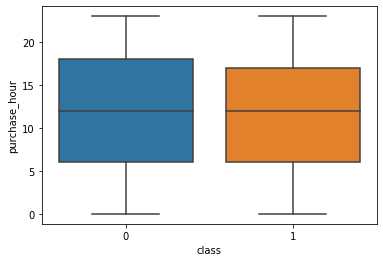

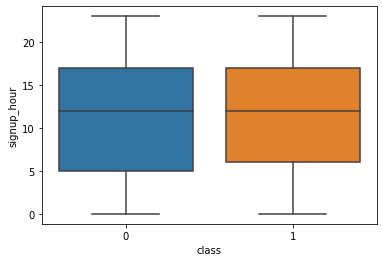

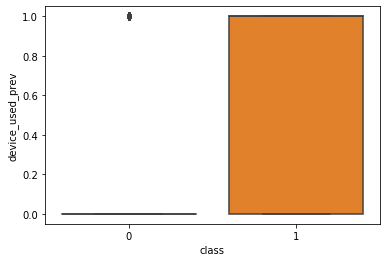

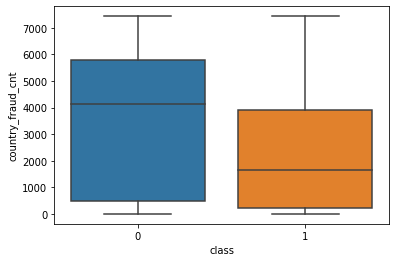

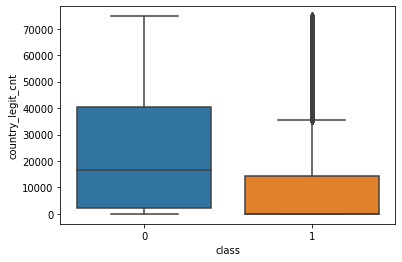

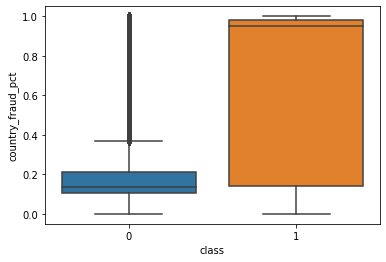

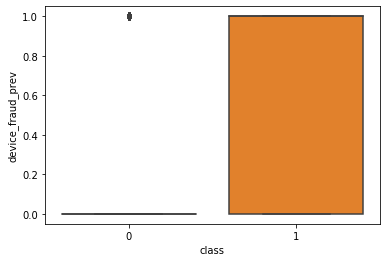

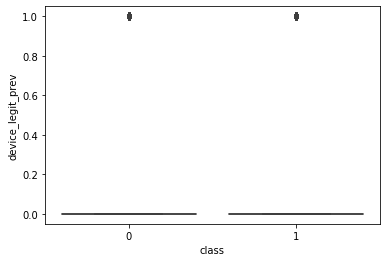

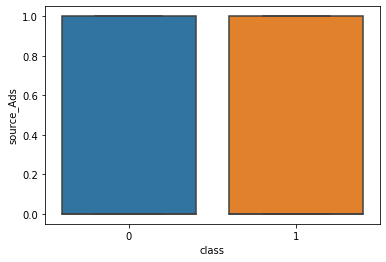

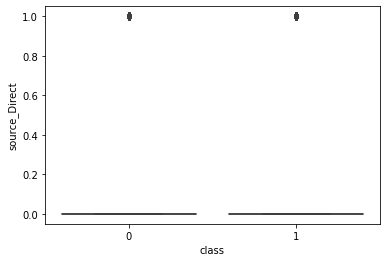

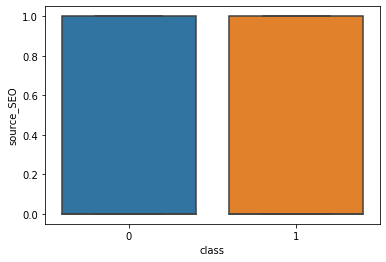

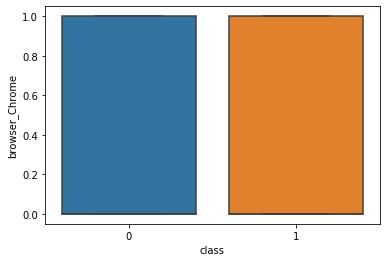

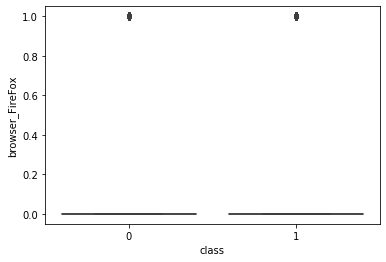

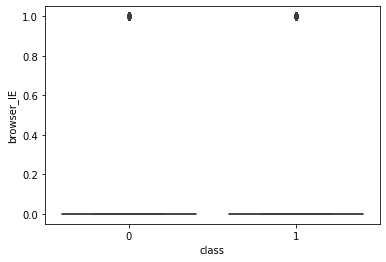

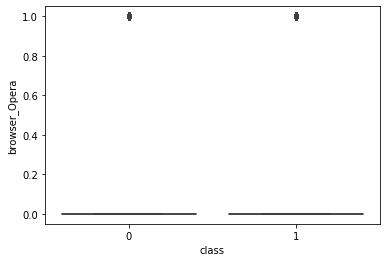

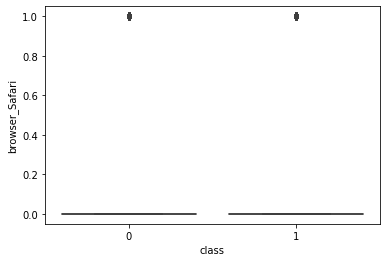

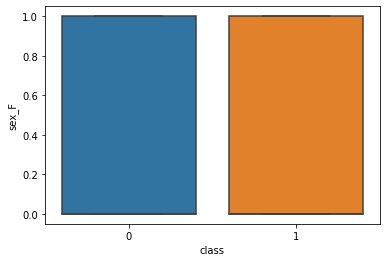

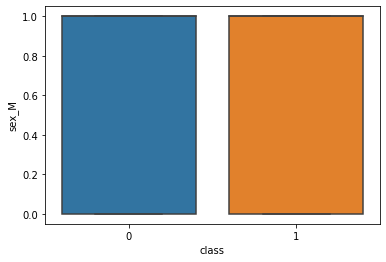

In [399]:
eda.boxplots(hue='class')

### Making dummies for source, browser, sex - *for modeling* – and backing up the final df to csv

In [413]:
df = pd.get_dummies(df, columns=['source', 'browser', 'sex'], drop_first=True)

In [417]:
ls

LICENSE.md             data/                  src/
README.md              notebooks/             yellowbrick-notes.pdf


In [419]:
df.to_csv("data/Fraud_Data_final.csv", index=False)

## **Modeling**

In [424]:
df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'age', 'ip_address', 'class', 'country', 'time_elapsed',
       'sub_minute', 'purchase_hour', 'signup_hour', 'device_used_prev',
       'country_fraud_cnt', 'country_legit_cnt', 'country_fraud_pct',
       'device_fraud_prev', 'device_legit_prev', 'source_Direct', 'source_SEO',
       'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari',
       'sex_M'],
      dtype='object')

In [434]:
#keeping only numeric, interpretable features for modeling
X_cols = ['purchase_value',
       'age', 'time_elapsed',
       'sub_minute', 'device_used_prev',
       'country_fraud_cnt', 'country_legit_cnt', 'country_fraud_pct',
       'device_fraud_prev', 'device_legit_prev', 'source_Direct', 'source_SEO',
       'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari',
       'sex_M']
y_col = 'class'

X = df.loc[:, X_cols].values
y = df.loc[:, y_col].values.ravel()
#need to use ravel for y array to be correct shape for analysis, 
#otherwise np.mean(y_pred == y_test) and other things do not work properly

print(X.shape)
print(y.shape)

print(np.mean(y == 1))

(151112, 17)
(151112,)
0.09364577267192546


In [439]:
#holding out a ~10% test set
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits = 10)
for train_index, test_index in tscv.split(X, y):
    X_train, y_train = scaler.fit(X[train_index]).transform(X[train_index]), y[train_index]
    X_test, y_test = scaler.fit(X[test_index]).transform(X[test_index]), y[test_index]
    if (X_train.shape[0] / X_test.shape[0]) > 8: #getting approx. 90/10 split
        break

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(109901, 17)
(109901,)
(13737, 17)
(13737,)


In [456]:
# double checking that data is sorted chronologically by purchase_time
problems = 0
indices = []
for i in range(1, len(df)):
    if df.at[i, 'purchase_time'] >= df.at[i-1, 'purchase_time']:
        continue
    else:
        problems += 1
        indices.append(i)

print("Problems:", str(problems))

Problems: 0


In [550]:
%%time
#let's model using the 90, then check performance on the held out 10

alphas = np.logspace(-3, 1, 25)
l1_ratios = [0, .25, .5, .75, 1]
parameters = {'l1_ratio': l1_ratios, 'alpha': alphas, 'class_weight': [None, 'balanced']}
elastic_net = SGDClassifier(loss='log', penalty='elasticnet', n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=5)
model = GridSearchCV(elastic_net, parameters, cv=tscv, n_jobs=-1)
model.fit(X_train, y_train)
print("-------- BEST MODEL --------")
print(model.best_estimator_)
print("-------- ---------- --------")
#1250 models

-------- BEST MODEL --------
SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
-------- ---------- --------
CPU times: user 6.47 s, sys: 1.4 s, total: 7.87 s
Wall time: 1min 53s


### Checking out the coefficients

In [471]:
interpreter = Classification(df, X_cols, y_col)

sub_minute           1.746916
device_used_prev     0.322328
source_Direct        0.122008
device_legit_prev    0.100812
country_fraud_pct    0.085693
device_fraud_prev    0.084663
sex_M                0.032168
browser_Opera        0.031844
purchase_value       0.030383
age                  0.007180
source_SEO           0.003560
country_fraud_cnt    0.001835
time_elapsed         0.001116
browser_FireFox     -0.002948
browser_IE          -0.004901
browser_Safari      -0.016735
country_legit_cnt   -0.017271
dtype: float64
Intercept   [-2.54322235]


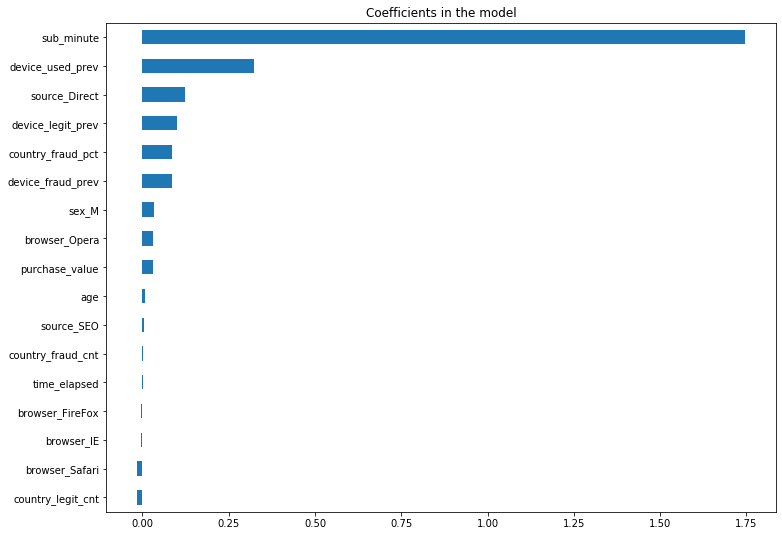

In [473]:
interpreter.coefficient_plot(model)

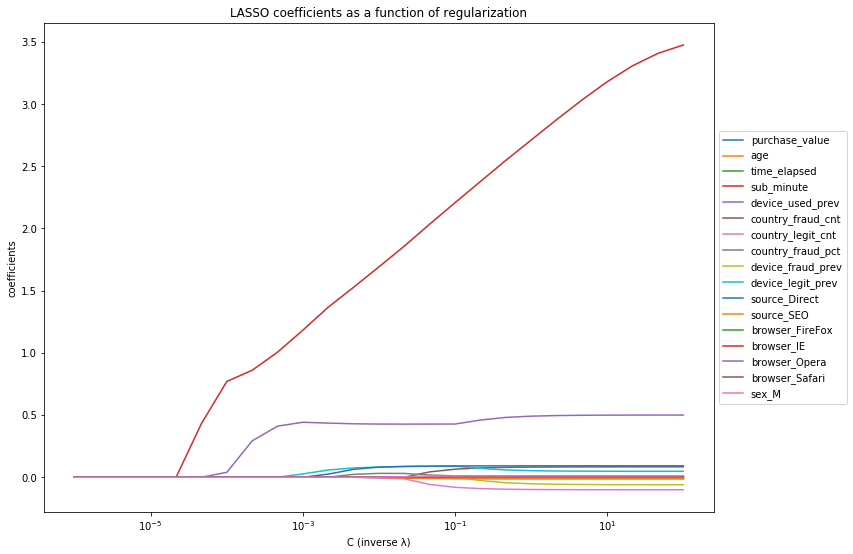

CPU times: user 2min 22s, sys: 310 ms, total: 2min 22s
Wall time: 2min 23s


In [476]:
%%time
interpreter.lasso_plot(np.logspace(2, -6, 25))

#### Looking at correlation matrix to get a sense of collinearity / counterintuitive coefficients...

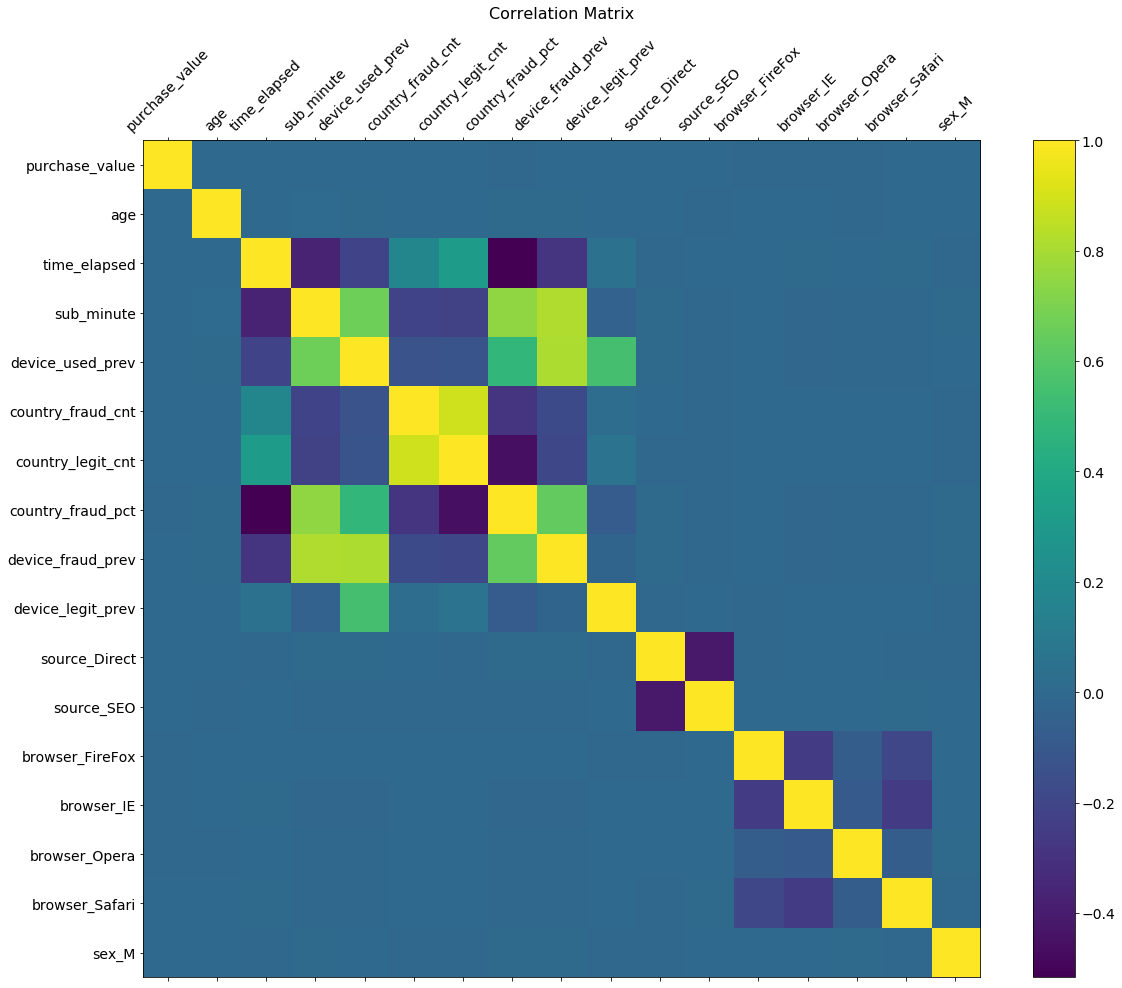

In [486]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(df[X_cols].corr(), fignum=f.number)
plt.xticks(range(df[X_cols].shape[1]), df[X_cols].columns, fontsize=14, rotation=45)
plt.yticks(range(df[X_cols].shape[1]), df[X_cols].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16, pad=80)

plt.show()

#### ...looks like collinearity may be messing with the coefficients - would probably drop some of the correlated features for better model interpretability

### Let's see how good the model is at predicting

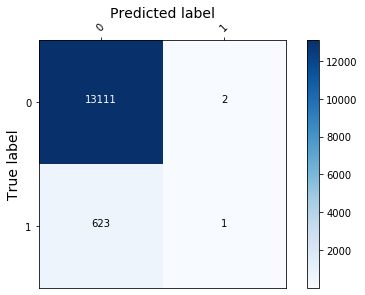

Accuracy =      0.955
Precision =     0.333
Recall (TPR) =  0.002
Fallout (FPR) = 0.000

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     13113
           1       0.33      0.00      0.00       624

    accuracy                           0.95     13737
   macro avg       0.64      0.50      0.49     13737
weighted avg       0.93      0.95      0.93     13737



In [489]:
preds = model.predict(X_test)
cm = ConfusionMatrix(y_test, preds, model)
cm.plot_matrix()
#not good at 50% decision boundary

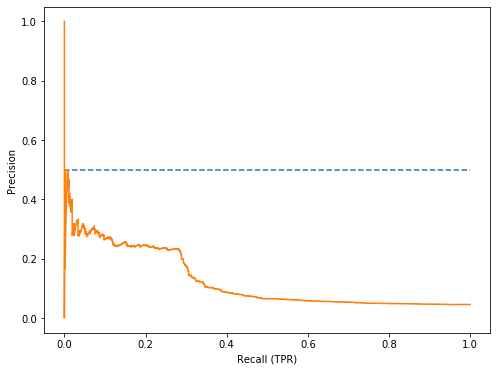

P/R ratio closest to 1: 0.9984
    Decision threshold: 0.2978780611121961
             Precision: 0.2336
                Recall: 0.23397435897435898


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [508]:
#precision-recall curve

probs = model.predict_proba(X_test) #predict probabilities
probs = probs[:, 1] #keep probabilities for the positive outcome only
precision, recall, thresholds = precision_recall_curve(y_test, probs) #calculate p-r curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0.5, 0.5], linestyle='--') #plot no skill
plt.plot(recall, precision) #plot the p-r curve for the model
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.show()

best_ratio = 0
best_thresh = 0
corresp_p = 0
corresp_r = 0
for p, r, t in zip(precision, recall, thresholds):
    if p/r < 1 and p/r > best_ratio:
        best_ratio = p/r
        best_thresh = t
        corresp_p = p
        corresp_r = r
print("P/R ratio closest to 1:", best_ratio)
print("    Decision threshold:", best_thresh)
print("             Precision:", corresp_p)
print("                Recall:", corresp_r)

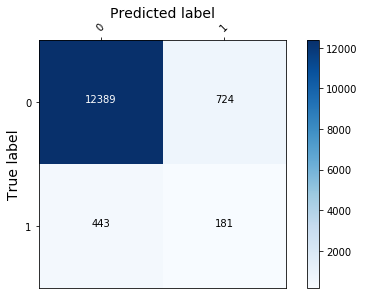

Accuracy =      0.915
Precision =     0.200
Recall (TPR) =  0.290
Fallout (FPR) = 0.055

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     13113
           1       0.20      0.29      0.24       624

    accuracy                           0.92     13737
   macro avg       0.58      0.62      0.60     13737
weighted avg       0.93      0.92      0.92     13737



In [533]:
preds_10 = (model.predict_proba(X_test)[:,1] >= 0.1).astype(bool)

cm = ConfusionMatrix(y_test, preds_10, model)
cm.plot_matrix()

#### Deciding on exact decision boundary would have to depend on cost-benefit analysis/profit curve
#### Could also try other models like KNN, SVM, RF, GB

## ------------

## Appendix: applying model to entire dataset

In [552]:
clf = Classification(df, X_cols, y_col)

In [554]:
model, preds = clf.elastic_net_sgd(alphas, l1_ratios, 5, time_series=True)

-------- BEST MODEL --------
SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
-------- ---------- --------


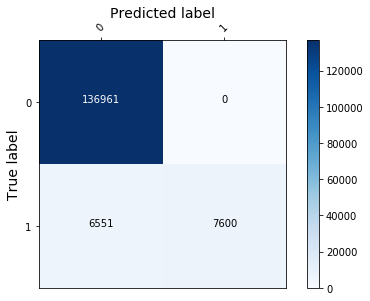

Accuracy =      0.957
Precision =     1.000
Recall (TPR) =  0.537
Fallout (FPR) = 0.000

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    136961
           1       1.00      0.54      0.70     14151

    accuracy                           0.96    151112
   macro avg       0.98      0.77      0.84    151112
weighted avg       0.96      0.96      0.95    151112



In [555]:
cm = ConfusionMatrix(df[y_col], preds, model)
cm.plot_matrix()

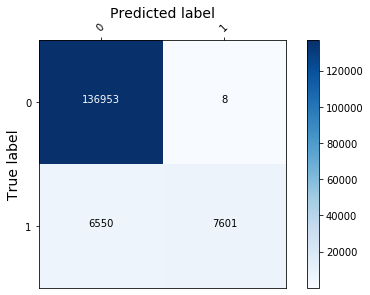

Accuracy =      0.957
Precision =     0.999
Recall (TPR) =  0.537
Fallout (FPR) = 0.000

---- Classification Report ----
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    136961
           1       1.00      0.54      0.70     14151

    accuracy                           0.96    151112
   macro avg       0.98      0.77      0.84    151112
weighted avg       0.96      0.96      0.95    151112



In [574]:
preds_10 = (model.predict_proba(X)[:,1] >= 0.1).astype(bool)

cm = ConfusionMatrix(df[y_col], preds_10, model)
cm.plot_matrix()